In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata
from tqdm import tqdm
import networkx as nx
import matplotlib.colors as mcolors
import re


root_dir = "../data_set"


In [ ]:
race_result = pd.read_csv(f'{root_dir}/allRriderResults2020_2024_clean.csv')
race_result.shape

/tmp/ipykernel_1208058/3588537081.py:1: DtypeWarning: Columns (8,75) have mixed types. Specify dtype option on import or set low_memory=False.
  race_result = pd.read_csv(f'{root_dir}/static_features_exp/data_sets/initial/allRriderResults2020_2024_clean.csv')


(386836, 88)

# Dataset Building

## Preprocess

Add teams ids and budgets

In [7]:
teams_info = pd.read_csv(root_dir + '/all_team_data_combined_with_id.csv')
teams_info.shape

(2630, 9)

In [373]:
race_result['date'] = pd.to_datetime(race_result['date'])
race_result['year'] = race_result['date'].dt.year

# Drop races from 2024
race_result = race_result[race_result['year'] < 2024]
race_result['classification'] =  race_result['classification'].astype('str')

race_result['classification'].value_counts()

classification
2.2         102636
2.UWT        82282
2.1          65939
2.Pro        55161
1.2          25988
1.1          25373
1.Pro        14972
1.UWT        10888
CC            1277
WC             979
1.2U           167
Olympics       167
JR              57
Name: count, dtype: int64

filter races that riders compete on behalf of their country rather than as a team('WC', 'Olympics', 'JR').

In [374]:
COUNTRIES = ['tanzania',
 'paraguay',
 'bangladesh',
 'mali',
 'costa rica',
 'croatia',
 'afghanistan',
 'china',
 'morocco',
 'denmark',
 'serbia',
 'japan',
 'zambia',
 'poland',
 'argentina',
 'syria',
 'great britain',
 'australia',
 'cuba',
 'zimbabwe',
 'norway',
 'romania',
 'montenegro',
 'kosovo',
 'czech republic',
 'loas',
 'uzbekistan',
 'myanmar',
 'united arab emirates',
 'mexico',
 'austria',
 'cameroon',
 'india',
 'turkey',
 'qatar',
 'chile',
 'bosnia and herzegovina',
 'hungary',
 'sri lanka',
 'scotland',
 'slovakia',
 'italy',
 'ukraine',
 'uruguay',
 'turkmenistan',
 'greece',
 'spain',
 'netherlands',
 'puerto rico',
 'iraq',
 'indonesia',
 'cyprus',
 'jamaica',
 'ireland',
 'nepal',
 'slovenia',
 'nigeria',
 'vietnam',
 'georgia',
 'united states',
 'portugal',
 'thailand',
 'kenya',
 'iran',
 'albania',
 'brazil',
 'israel',
 'germany',
 'south korea',
 'bulgaria',
 'lebanon',
 'switzerland',
 'oman',
 'finland',
 'macedonia',
 'yemen',
 'saudi arabia',
 'malaysia',
 'colombia',
 'belarus',
 'sabon',
 'latvia',
 'venezuela',
 'kazakhstan',
 'jordan',
 'canada',
 'sweden',
 'luxembourg',
 'ghana',
 'bahrain',
 'russia',
 'lithuania',
 'estonia',
 'dominican republic',
 'armenia',
 'algeria',
 'peru',
 'azerbaijan',
 'ethiopia',
 'panama',
 'new zealand',
 'ecuador',
 'philippines',
 'pakistan',
 'south africa',
 'belgium',
 'kyrgyzstan',
 'tajikistan',
 'france',
 'uganda']

In [375]:
def preproccess_teams(races_results, countries_names):
    # Convert to lowercase and make the list unique
    countries = list(set([country.lower() for country in countries_names]))
    filter_races = ['WC', 'Olympics', 'JR']

    missing_teams = races_results[(races_results['team'].isna()) & \
    (~races_results['classification'].isin(filter_races))][['rider', 'year']].drop_duplicates()
    
    riders_with_no_team = []
    races_results_with_team = races_results.copy()

    # Iterate through the missing team entries
    for index, row in missing_teams.iterrows():
        rider = row['rider']
        year = row['year']
        
        # Find all records of this rider in the same year with a non-null team
        possible_teams = races_results_with_team[(races_results_with_team['rider'] == rider) & 
                                                    (races_results_with_team['year'] == year) & 
                                                    races_results_with_team['team'].notna()]['team'].unique()
        
        if len(possible_teams) > 0:
            # Check if there are multiple possible teams
            if len(possible_teams) > 1:
                
                for team in possible_teams:
                    team_lower = team.lower()
                    # Check if the team name contains a country name 
                    if (team_lower not in countries):
                        fill_team = team

            else:
                # If there's only one team, use it to fill
                fill_team = possible_teams[0]

            # Fill the missing team values
            races_results_with_team.loc[(races_results_with_team['rider'] == rider) & 
                                        (races_results_with_team['year'] == year) & 
                                        (races_results_with_team['team'].isna()), 'team'] = fill_team
        else:
            riders_with_no_team.append((rider, year))
    
    print(f"Number of riders with no team: {len(riders_with_no_team)}")
    races_results_with_team.dropna(subset=['team'], inplace=True)

    return races_results_with_team

In [376]:
race_result_teams = preproccess_teams(race_result, COUNTRIES)

Number of riders with no team: 90


In [377]:
def normalize_team_name(name):
    """
    Normalize a team name by:
    - Converting to lowercase
    - Removing spaces, hyphens, and question marks
    - Replacing accented characters with their ASCII equivalent
    """
    # Convert accented characters to their ASCII equivalent
    name = unicodedata.normalize('NFKD', name).encode('ASCII', 'ignore').decode('utf-8')
    
    # Remove spaces, hyphens, and question marks, and convert to lowercase
    name = re.sub(r'[\s\-?]', '', name.lower())
    
    return name

def add_team_id(races_results_df, teams_info_df, countries):
    # Normalize the team names in both DataFrames
    races_results_df['team_name_reduced'] = races_results_df['team'].apply(normalize_team_name)
    teams_info_df['team_name_reduced'] = teams_info_df['team'].apply(normalize_team_name)
    countries_reduced = [normalize_team_name(country) for country in countries]

    # Display the team names that are missing from team info that are not countries
    missing_teams = set(races_results_df['team_name_reduced'].unique()).difference(set(teams_info_df['team_name_reduced'].unique()))
    missing_teams = [team for team in missing_teams if team not in countries_reduced]
    missing_teams_names = races_results_df[races_results_df['team_name_reduced'].isin(missing_teams)]['team'].unique()
    print(f"Number of missing teams: {len(missing_teams)}")
    print(f"Missing teams: {missing_teams_names}")

    # Merge the team id from team info
    team_ids = teams_info_df[['team_name_reduced','team_gen_id']].drop_duplicates()
    races_results_team_id = pd.merge(races_results_df, team_ids, how='left', on='team_name_reduced')
    return races_results_team_id

def add_general_team_features(races_results_df, teams_info_df, team_types_to_keep, countries):
    # Add team_gen_id to the DataFrame
    races_results_with_id = add_team_id(races_results_df, teams_info_df, countries)

    # Merge the team id from team info
    # Step 1: Merge by 'team_gen_id' first (using last season's data)
    teams_info_df['year_plus'] = teams_info_df['year'] + 1

    teams_ids = teams_info_df[['team_gen_id', 'year_plus', 'team_score', 'team_rank', 'team_class']].drop_duplicates(subset=['team_gen_id', 'year_plus'])
    merged_by_id = pd.merge(races_results_with_id, teams_ids,
                    left_on=['team_gen_id', 'year'], right_on=['team_gen_id', 'year_plus'], how='left')

    print('Number of missing team info after merging by team id:', merged_by_id[['team_score', 'team_rank', 'team_class']].isna().any(axis=1).sum())
    # Check which teams missing data 
    missing_teams_counts = merged_by_id[(merged_by_id[['team_score', 'team_rank', 'team_class']].isna().any(axis=1))]['team'].value_counts().sort_values(ascending=False)
    print('Team counts with missing scores: ', missing_teams_counts[missing_teams_counts > 500])

    # Filter
    race_results_teams = merged_by_id[~(merged_by_id[['team_score', 'team_rank', 'team_class']].isna()).any(axis=1)].copy()

    # Transform 'PCT' to 'PRT' in 'team_class and don't include 'CLUB' teams
    race_results_teams['team_class'] = race_results_teams['team_class'].apply(lambda x: 'PRT' if x == 'PCT' else x)

    # Drop certain team types
    races_results_rel_team = race_results_teams[race_results_teams['team_class'].isin(team_types_to_keep)]

    return races_results_rel_team

In [378]:
teams_info_rel = teams_info[teams_info['team_class'] != 'CT']

In [379]:
team_types_to_keep = ['WT', 'PRT', 'PCT']
team_result_ids = add_general_team_features(race_result_teams, teams_info, team_types_to_keep, COUNTRIES)
team_result_ids.shape

Number of missing teams: 1232
Missing teams: ['Iraq Cycling Project' 'Vino SKO Team' 'Velo Bursa Bisiklet Takimi' ...
 'Faucon Flacq KFC Pepsi Cycling Club' 'Cyclo Club Bénédictin'
 'Velo Club des Jeunes de Curepipe']
Number of missing team info after merging by team id: 117660
Team counts with missing scores:  team
Germany                                     748
Italy                                       747
Algeria                                     691
P&S Benotti                                 624
Atum general / Tavira / Maria Nova Hotel    605
General Store - Essegibi - F.Lli Curia      601
Serbia                                      600
Movistar - Best PC                          596
Beltrami TSA - Tre Colli                    587
Morocco                                     586
Team U Nantes Atlantique                    585
ProTouch                                    577
Switzerland                                 565
St Michel - Mavic - Auber93                 556
Panamá es 

(190640, 93)

In [380]:
team_result_ids[team_result_ids['year'] == 2023][['team', 'team_gen_id']].drop_duplicates()

team  team_gen_id
448               Team Flanders - Baloise       1453.0
449          Intermarché - Circus - Wanty       1490.0
451                               Cofidis       1136.0
453                     Team Arkéa Samsic       1107.0
454                     AG2R Citroën Team       1060.0
455                           Lotto Dstny       2088.0
459                   Soudal - Quick Step       1328.0
461                        Groupama - FDJ       1187.0
464                 Astana Qazaqstan Team       1375.0
465                            Bingoal WB       1482.0
467                         TotalEnergies       1175.0
468                    Equipo Kern Pharma       7807.0
487                           Jumbo-Visma       1330.0
527                  Human Powered Health       1235.0
3961                   Alpecin-Deceuninck       1100.0
3962                    Team Novo Nordisk       1430.0
3976                             Team DSM       1360.0
4498   Green Project-Bardiani CSF-Faizanè       3345.0
4528                AG2R Citroën U23 Team      10490.0
6748               Q36.5 Pro Cycling Team       1293.0
6749                        Movistar Team       2040.0
6752                     Team Jayco AlUla       1207.0
6758                EF Education-EasyPost       4000.0
6767                     Trek - Segafredo       1258.0
6774                     INEOS Grenadiers       1423.0
6775                Israel - Premier Tech       2738.0
6788                    UAE Team Emirates       1253.0
6789                 Bahrain - Victorious       3814.0
6797                     BORA - hansgrohe       1411.0
7304                  Euskaltel - Euskadi       4831.0
7614                 Team dsm - firmenich       1360.0
7626                            Burgos-BH       1109.0
7628                          Lidl - Trek       1258.0
10582                         EOLO-Kometa       4723.0
19405            Caja Rural - Seguros RGA       1111.0
33604                 GW Shimano-Sidermec       2925.0

Add team budget

In [381]:
team_result_ids['team_class'].value_counts()

team_class
WT     120285
PRT     70355
Name: count, dtype: int64

In [382]:
team_budgets = pd.read_csv(root_dir + '/miki_project/data_set/teams_budget.csv')
team_budgets.shape

(18, 5)

In [383]:
# Merge the team budgets by team_gen_id
team_budgets.drop(columns=['Team'], inplace=True)
team_with_budget = pd.merge(team_result_ids, team_budgets, how='left', on='team_gen_id')
team_with_budget['Budget Category'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 190640 entries, 0 to 190639
Series name: Budget Category
Non-Null Count   Dtype 
--------------   ----- 
105965 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [384]:
team_with_budget['Budget Category'] = team_with_budget['Budget Category'].fillna('Low')
team_with_budget['Budget Category'].value_counts()

Budget Category
Low       124208
Medium     47124
High       19308
Name: count, dtype: int64

## Aggregate to team-race level features

First rank the teams per race by two keys, best rank achieved by team rider and the total points gained by all team members

In [385]:
def rank_teams(teams_df):
    # Rank teams in a race by its best rider rank 
    teams_df['best_rider_rank'] = teams_df.groupby(['race', 'date', 'team_gen_id'])['rank_number'].transform('min')

    # Rank teams in a race by its total number of points gained
    teams_df['bonus'] = teams_df['bonus'].fillna(0)
    teams_df['points'] = teams_df['points'].fillna(0)
    teams_df['rider_race_points'] = teams_df['points'] + teams_df['bonus']
    teams_df['team_total_points'] = teams_df.groupby(['race', 'date', 'team_gen_id'])['rider_race_points'].transform('sum')

    # Order teams by best rider rank for each race
    teams_df['team_race_rank_best_rider'] = (
        teams_df.groupby(['race', 'date'])['best_rider_rank']
        .rank(method='dense', ascending=True)
        .astype(int)
    )

    # Order teams by total points for each race
    teams_df['team_race_rank_points'] = (
        teams_df.groupby(['race', 'date'])['team_total_points']
        .rank(method='dense', ascending=False)
        .astype(int)
    )   

    return teams_df

In [386]:
teams_ranked_budget = rank_teams(team_with_budget)
teams_ranked_budget[['team_race_rank_best_rider', 'team_race_rank_points']].describe()

team_race_rank_best_rider  team_race_rank_points
count              190640.000000          190640.000000
mean                    9.251883               5.957391
std                     5.981419               3.800868
min                     1.000000               1.000000
25%                     4.000000               3.000000
50%                     8.000000               5.000000
75%                    14.000000               7.000000
max                    27.000000              23.000000

In [387]:
# Here, 'rank-pts' is the general points rank, and 'rank-pts-1', 'rank-pts-2', ... represent specific terrains.
ranking_columns = ['rank-pts', 'rank-uci']
general_points = ['totalPts', 'totalUciPts']

# Extend the list with terrain-specific columns for both pts and uci.
terrain_types = ['1', '2', '3', '4', '5', 'tt', 'gc']
ranking_columns += [f"rank-pts-{t}" for t in terrain_types]
ranking_columns += [f"rank-uci-{t}" for t in terrain_types]
points_columns = [f"pts-{t}" for t in terrain_types]
points_columns += [f"uci-{t}" for t in terrain_types]
teams_ranked_budget[points_columns+ranking_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190640 entries, 0 to 190639
Data columns (total 30 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   pts-1        152004 non-null  float64
 1   pts-2        152004 non-null  float64
 2   pts-3        152004 non-null  float64
 3   pts-4        152004 non-null  float64
 4   pts-5        152004 non-null  float64
 5   pts-tt       152004 non-null  float64
 6   pts-gc       152004 non-null  float64
 7   uci-1        152004 non-null  float64
 8   uci-2        152004 non-null  float64
 9   uci-3        152004 non-null  float64
 10  uci-4        152004 non-null  float64
 11  uci-5        152004 non-null  float64
 12  uci-tt       152004 non-null  float64
 13  uci-gc       152004 non-null  float64
 14  rank-pts     152004 non-null  float64
 15  rank-uci     152004 non-null  float64
 16  rank-pts-1   152004 non-null  float64
 17  rank-pts-2   152004 non-null  float64
 18  rank-pts-3   152004 non-

In [388]:
missing_rider_points = teams_ranked_budget[(teams_ranked_budget[ranking_columns].isna().any(axis=1)) & (teams_ranked_budget['year']>2020)][['rider', 'age', 'team','year']].drop_duplicates()
missing_rider_points.head()

rider   age                          team  year
28     LEIJNSE Enzo  20.0                      Team DSM  2022
44   VERMOTE Julien  32.0                 Alpecin-Fenix  2022
86      DE LIE Axel  24.0                   Lotto Dstny  2023
87       HUENS Axel  21.0  Intermarché - Circus - Wanty  2023
115      KUHN Kevin  25.0  Intermarché - Circus - Wanty  2023

In [389]:
missing_rider_points['age'].describe()

count    398.000000
mean      22.412060
std        4.386957
min       18.000000
25%       20.000000
50%       21.000000
75%       23.000000
max       40.000000
Name: age, dtype: float64

In [390]:
# --- Step 1: Flag new riders before filling missing values.
# Create a new boolean column 'new_rider' that is True for riders under 24 
# who have any missing ranking value (in any ranking column) and are from year > 2020.
teams_ranked_budget['new_rider'] = (
    (teams_ranked_budget['age'] < 24) & 
    (teams_ranked_budget['year'] > 2020) &
    (teams_ranked_budget[ranking_columns].isna().any(axis=1))
)

# --- Step 2: For each ranking column, fill missing values with the current group's year max rank.
# This assumes that within each (year, team), a missing value should be replaced with the worst (largest) rank.
for col in ranking_columns:
    teams_ranked_budget[col] = teams_ranked_budget.groupby('year')[col] \
                                                   .transform(lambda x: x.fillna(x.max()))
    teams_ranked_budget[col] = teams_ranked_budget[col].transform(lambda x: x.fillna(x.max()))
    
# --- Step 3: For the points columns, fill missing values with 0.
for col in points_columns:
    teams_ranked_budget[col] = teams_ranked_budget[col].fillna(0)

# --- Optional: Check the missing rider points subset.
missing_rider_points = teams_ranked_budget[
    (teams_ranked_budget[ranking_columns].isna().any(axis=1)) & 
    (teams_ranked_budget['year'] > 2020)
][['rider', 'age', 'team', 'year']].drop_duplicates()

print(missing_rider_points.head())

Empty DataFrame
Columns: [rider, age, team, year]
Index: []


For each season and each team, I want to isolate the group of riders and then compute the internal ranking based on the external (last season) rank for each racing terrain type or category, in the following list:

- 1 - Flat
- 2 - Hills, flat finish
- 3 - Hills, uphill finish
- 4 - Mountains, flat finish
- 5 - Mountains, uphill finish
- tt - Time Trial
- gc - Genral Classification

In [391]:
# Filter 2020 races
teams_ranked_rel = teams_ranked_budget[teams_ranked_budget['year'] > 2020]

In [392]:
# ------------------------------------------
# Step 1: Deduplicate the DataFrame by rider for each year and team.
# ------------------------------------------
# Assume teams_ranked_budget is your original DataFrame.
teams_unique = teams_ranked_rel.drop_duplicates(subset=['year', 'team_gen_id', 'rider']).copy()

# ------------------------------------------
# Step 2: Compute the Internal Rankings for each ranking column.
# ------------------------------------------
# Compute internal rankings within each (year, team_gen_id) group.
internal_ranking_columns = []
for col in ranking_columns:
    new_col = 'internal_' + col.replace('-', '_')
    internal_ranking_columns.append(new_col)
    teams_unique[new_col] = teams_unique.groupby(['year', 'team_gen_id'])[col].rank(method='min')

teams_unique[internal_ranking_columns].head()


internal_rank_pts  internal_rank_uci  internal_rank_pts_1  \
0               14.0               14.0                 32.0   
1               18.0                1.0                 20.0   
2               10.0               16.0                 14.0   
3               15.0               19.0                 24.0   
4               14.0               10.0                 22.0   

   internal_rank_pts_2  internal_rank_pts_3  internal_rank_pts_4  \
0                 13.0                 34.0                  1.0   
1                 20.0                  1.0                  1.0   
2                  7.0                 13.0                 18.0   
3                 19.0                 16.0                  1.0   
4                 21.0                 22.0                  1.0   

   internal_rank_pts_5  internal_rank_pts_tt  internal_rank_pts_gc  \
0                  1.0                  21.0                  26.0   
1                  1.0                  20.0                   1.0   
2                  1.0                  13.0                  19.0   
3                  1.0                   1.0                  21.0   
4                  1.0                   1.0                  22.0   

   internal_rank_uci_1  internal_rank_uci_2  internal_rank_uci_3  \
0                 32.0                 14.0                  1.0   
1                  1.0                  1.0                  1.0   
2                  1.0                 15.0                  1.0   
3                  1.0                 23.0                 17.0   
4                 30.0                 14.0                 24.0   

   internal_rank_uci_4  internal_rank_uci_5  internal_rank_uci_tt  \
0                  1.0                  1.0                   1.0   
1                  1.0                  1.0                   1.0   
2                  1.0                  1.0                   1.0   
3                  1.0                  1.0                   1.0   
4                  1.0                  1.0                   1.0   

   internal_rank_uci_gc  
0                  33.0  
1                   1.0  
2                  19.0  
3                  24.0  
4                  18.0

When multiple records have the same value, using rank(method='min') assigns all of those tied records the smallest (minimum) rank that would be assigned if they were sorted in ascending order.

In [393]:
teams_unique.groupby(['year', 'team_gen_id']).size().describe()

count    106.000000
mean      30.707547
std       10.728659
min       11.000000
25%       24.000000
50%       30.000000
75%       33.000000
max       85.000000
dtype: float64

In [394]:
import numpy as np
import pandas as pd

def equal_width_discretization(s, n):
    """
    Discretize the Series s into n bins of equal width based on the number of observations in the group.
    Assumes s contains ranking values for a given group.
    
    If all values in s are the same, return a Series of 1's.
    
    Parameters:
      s (pd.Series): The ranking values (e.g. internal ranks).
      n (int): The number of equal-width bins.
    
    Returns:
      pd.Series: A Series of bin labels (integers from 1 to n) for each value in s.
    """
    # If all ranks are the same, then everyone falls in the top bin.
    if s.nunique() == 1:
        return pd.Series(np.ones(len(s), dtype=int), index=s.index)
    
    # Number of participating riders in the group.
    group_size = len(s)
    
    # Calculate the bin width based on the group size.
    # For example, if there are 30 riders and n=5, bin_width = ceil(30/5)=6.
    bin_width = int(np.ceil(group_size / n))
    
    # Assign each value to a bin by dividing by the bin width and taking the ceiling.
    # For example, rank 7 with a bin_width of 6 gives ceil(7/6)=2.
    bins = np.ceil(s / bin_width).astype(int)
    
    # In case rounding pushes some values above n, cap them at n.
    bins = np.clip(bins, 1, n)
    return pd.Series(bins, index=s.index)

# Function to add equal width discretization columns to the dataframe for each internal ranking column.
def add_equal_width_categories(df, internal_cols, n_bins):
    for col in internal_cols:
        new_col = 'ew_cat_' + col
        # Group by year and team, then apply equal width discretization on each group.
        df[new_col] = df.groupby(['year', 'team_gen_id'])[col].transform(lambda s: equal_width_discretization(s, n_bins))
    return df

# Example usage:
# Assume teams_unique is your deduplicated DataFrame with internal ranking columns already computed.
n_bins = 5
teams_unique = add_equal_width_categories(teams_unique, internal_ranking_columns, n_bins)

# Now, for example, 'ew_cat_internal_rank_pts' is the equal-width categorical bin for the internal rank for points.
print(teams_unique[teams_unique['year'] == 2022].groupby('team_gen_id')[['ew_cat_internal_rank_pts', 'ew_cat_internal_rank_uci']].describe())

            ew_cat_internal_rank_pts                                          \
                               count      mean       std  min  25%  50%  75%   
team_gen_id                                                                    
1060.0                          33.0  2.878788  1.386488  1.0  2.0  3.0  4.0   
1100.0                          42.0  2.714286  1.174645  1.0  2.0  3.0  4.0   
1107.0                          34.0  2.941176  1.412953  1.0  2.0  3.0  4.0   
1109.0                          24.0  2.916667  1.411649  1.0  2.0  3.0  4.0   
1111.0                          24.0  2.916667  1.411649  1.0  2.0  3.0  4.0   
1136.0                          34.0  2.941176  1.412953  1.0  2.0  3.0  4.0   
1175.0                          28.0  2.857143  1.380131  1.0  2.0  3.0  4.0   
1187.0                          41.0  2.804878  1.345725  1.0  2.0  3.0  4.0   
1207.0                          33.0  2.878788  1.386488  1.0  2.0  3.0  4.0   
1235.0                          22.0  2.

In [395]:
# ------------------------------------------
# Step 4: Merge the computed features back into the original DataFrame.
# ------------------------------------------
# Identify the columns to merge from teams_unique:
bins_cols = [f'ew_cat_{col}' for col in internal_ranking_columns]
merge_cols = ['year', 'team_gen_id', 'rider'] + internal_ranking_columns + bins_cols
              
# Merge using a left join so that every record in teams_ranked_budget gets the new features.
teams_combined = pd.merge(
    teams_ranked_budget,
    teams_unique[merge_cols],
    on=['year', 'team_gen_id', 'rider'],
    how='left'
)

cat_cols = [col for col in teams_combined.columns if col.startswith('ew_cat')]
teams_combined[cat_cols].describe()

ew_cat_internal_rank_pts  ew_cat_internal_rank_uci  \
count             156416.000000             156416.000000   
mean                   2.581219                  2.704813   
std                    1.279125                  1.268466   
min                    1.000000                  1.000000   
25%                    1.000000                  2.000000   
50%                    2.000000                  3.000000   
75%                    4.000000                  4.000000   
max                    5.000000                  5.000000   

       ew_cat_internal_rank_pts_1  ew_cat_internal_rank_pts_2  \
count               156416.000000               156416.000000   
mean                     2.683984                    2.725533   
std                      1.376745                    1.262452   
min                      1.000000                    1.000000   
25%                      1.000000                    2.000000   
50%                      3.000000                    3.000000   
75%                      4.000000                    4.000000   
max                      5.000000                    5.000000   

       ew_cat_internal_rank_pts_3  ew_cat_internal_rank_pts_4  \
count               156416.000000               156416.000000   
mean                     2.734663                    2.338744   
std                      1.321097                    1.539956   
min                      1.000000                    1.000000   
25%                      1.000000                    1.000000   
50%                      3.000000                    1.000000   
75%                      4.000000                    4.000000   
max                      5.000000                    5.000000   

       ew_cat_internal_rank_pts_5  ew_cat_internal_rank_pts_tt  \
count               156416.000000                156416.000000   
mean                     2.429285                     2.538142   
std                      1.520426                     1.401043   
min                      1.000000                     1.000000   
25%                      1.000000                     1.000000   
50%                      2.000000                     3.000000   
75%                      4.000000                     4.000000   
max                      5.000000                     5.000000   

       ew_cat_internal_rank_pts_gc  ew_cat_internal_rank_uci_1  \
count                156416.000000               156416.000000   
mean                      2.694430                    2.045922   
std                       1.328024                    1.507053   
min                       1.000000                    1.000000   
25%                       1.000000                    1.000000   
50%                       3.000000                    1.000000   
75%                       4.000000                    4.000000   
max                       5.000000                    5.000000   

       ew_cat_internal_rank_uci_2  ew_cat_internal_rank_uci_3  \
count               156416.000000               156416.000000   
mean                     2.684259                    2.337964   
std                      1.372206                    1.529037   
min                      1.000000                    1.000000   
25%                      1.000000                    1.000000   
50%                      3.000000                    1.000000   
75%                      4.000000                    4.000000   
max                      5.000000                    5.000000   

       ew_cat_internal_rank_uci_4  ew_cat_internal_rank_uci_5  \
count               156416.000000               156416.000000   
mean                     1.491587                    1.588667   
std                      1.242548                    1.332818   
min                      1.000000                    1.000000   
25%                      1.000000                    1.000000   
50%                      1.000000                    1.000000   
75%                      1.000000                    1

In [396]:
teams_combined['parcoursType'].value_counts()

parcoursType
2.0    66769
3.0    32719
1.0    30175
5.0    22072
gc     16780
tt     11438
4.0    10687
Name: count, dtype: int64

Add points scale shift increase by year

In [38]:
points_shift = pd.read_csv(root_dir + '/points_scale_shift.csv')
points_shift.head()

pointsScale  2022 Total Points  2023 Total Points  \
0        GT.A               6690               8735   
1        GT.B               5477               7135   
2   Worlds.RR               3750               5600   
3      1.WT.A               3130               5110   
4        2.WT               1940               3205   

   points_increase_percentage  
0                        30.6  
1                        30.3  
2                        49.3  
3                        63.3  
4                        65.2

In [398]:
teams_combined['pointsScale'].value_counts()

pointsScale
2.WT.Stage     35546
2.PRO.Stage    32052
2.1.Stage      25908
GT.B.Stage     25661
1.1            15148
GT.A.Stage     13181
1.PRO          11977
1.WT.B          7381
2.PRO           5511
2.1             5063
2.WT            3957
1.WT.A          3214
2.2.Stage       2551
GT.B            1103
GT.A             564
1.2              531
2.2              483
2.WT.TTT          14
J-1.1              7
Name: count, dtype: int64

In [399]:
# Merge the points shift by points scale
teams_points_shift = pd.merge(teams_combined, points_shift[['pointsScale', 'points_increase_percentage']], how='inner', on='pointsScale')
teams_points_shift['points_increase_percentage'].describe()

count    189831.000000
mean        126.877020
std         138.589829
min           0.000000
25%           0.000000
50%          51.400000
75%         252.500000
max         338.600000
Name: points_increase_percentage, dtype: float64

In [400]:
# Assume 'df' is your DataFrame and it contains columns 'team_gen_id', 'year', and 'rider'.
unique_counts = teams_points_shift.groupby(['team_gen_id', 'year'])['rider'].nunique().reset_index()
unique_counts = unique_counts.rename(columns={'rider': 'team_riders_count'})

# Merge back into the original DataFrame
teams_riders_ranking = teams_points_shift.merge(unique_counts, on=['team_gen_id', 'year'], how='left')
teams_riders_ranking['team_riders_count'].describe()

count    189831.000000
mean         32.370224
std          10.352621
min           9.000000
25%          28.000000
50%          31.000000
75%          34.000000
max          85.000000
Name: team_riders_count, dtype: float64

In [402]:
teams_riders_ranking = teams_riders_ranking[teams_riders_ranking['team_riders_count'] <= 35]

In [403]:
# Filter 2020
# Save the final dataset
teams_riders_ranking.to_csv(root_dir + '/miki_project/data_set/teams_riders_ranking_all.csv', index=False)

## Teams-level Feature Extraction

In [13]:
teams_riders_ranking = pd.read_csv(root_dir + '/teams_riders_ranking_all.csv')
teams_riders_ranking.shape

(150405, 136)

In [14]:
internal_ranking_columns = [col for col in teams_riders_ranking.columns if col.startswith('internal_rank')]
bins_cols = [col for col in teams_riders_ranking.columns if col.startswith('ew_cat_internal_rank')]
teams_riders_ranking[internal_ranking_columns].describe()

internal_rank_pts  internal_rank_uci  internal_rank_pts_1  \
count      119123.000000      119123.000000        119123.000000   
mean           13.526649          14.247039            13.391772   
std             8.340303           8.352028             9.851566   
min             1.000000           1.000000             1.000000   
25%             6.000000           8.000000             1.000000   
50%            13.000000          14.000000            15.000000   
75%            20.000000          21.000000            21.000000   
max            34.000000          34.000000            34.000000   

       internal_rank_pts_2  internal_rank_pts_3  internal_rank_pts_4  \
count        119123.000000        119123.000000        119123.000000   
mean             14.312165            14.013843            10.693938   
std               8.421086             9.230005            11.086118   
min               1.000000             1.000000             1.000000   
25%               8.000000             7.000000             1.000000   
50%              14.000000            15.000000             1.000000   
75%              21.000000            21.000000            21.000000   
max              34.000000            34.000000            34.000000   

       internal_rank_pts_5  internal_rank_pts_tt  internal_rank_pts_gc  \
count        119123.000000         119123.000000         119123.000000   
mean             11.373597             12.356799             13.704188   
std              10.966067             10.077596              9.329283   
min               1.000000              1.000000              1.000000   
25%               1.000000              1.000000              5.000000   
50%              10.000000             13.000000             14.000000   
75%              21.000000             21.000000             21.000000   
max              34.000000             34.000000             34.000000   

       internal_rank_uci_1  internal_rank_uci_2  internal_rank_uci_3  \
count        119123.000000        119123.000000        119123.000000   
mean              8.328224            13.371775            10.677745   
std              10.986522             9.820975            11.074705   
min               1.000000             1.000000             1.000000   
25%               1.000000             1.000000             1.000000   
50%               1.000000            15.000000             1.000000   
75%              20.000000            21.000000            21.000000   
max              34.000000            34.000000            34.000000   

       internal_rank_uci_4  internal_rank_uci_5  internal_rank_uci_tt  \
count        119123.000000        119123.000000         119123.000000   
mean              4.423529             5.171982              6.570780   
std               8.805420             9.527593             10.186197   
min               1.000000             1.000000              1.000000   
25%               1.000000             1.000000              1.000000   
50%               1.000000             1.000000              1.000000   
75%               1.000000             1.000000              1.000000   
max              34.000000            34.000000             34.000000   

       internal_rank_uci_gc  
count         119123.000000  
mean              13.561025  
std                9.588573  
min                1.000000  
25%                1.000000  
50%               15.000000  
75%               21.000000  
max               33.000000

In [15]:
teams_riders_ranking[bins_cols].describe()

ew_cat_internal_rank_pts  ew_cat_internal_rank_uci  \
count             119123.000000             119123.000000   
mean                   2.631608                  2.759031   
std                    1.303216                  1.293960   
min                    1.000000                  1.000000   
25%                    1.000000                  2.000000   
50%                    3.000000                  3.000000   
75%                    4.000000                  4.000000   
max                    5.000000                  5.000000   

       ew_cat_internal_rank_pts_1  ew_cat_internal_rank_pts_2  \
count               119123.000000               119123.000000   
mean                     2.718501                    2.781797   
std                      1.419538                    1.286985   
min                      1.000000                    1.000000   
25%                      1.000000                    2.000000   
50%                      3.000000                    3.000000   
75%                      4.000000                    4.000000   
max                      5.000000                    5.000000   

       ew_cat_internal_rank_pts_3  ew_cat_internal_rank_pts_4  \
count               119123.000000               119123.000000   
mean                     2.781159                    2.367150   
std                      1.348626                    1.571503   
min                      1.000000                    1.000000   
25%                      1.000000                    1.000000   
50%                      3.000000                    1.000000   
75%                      4.000000                    4.000000   
max                      5.000000                    5.000000   

       ew_cat_internal_rank_pts_5  ew_cat_internal_rank_pts_tt  \
count               119123.000000                119123.000000   
mean                     2.460633                     2.579082   
std                      1.556522                     1.441627   
min                      1.000000                     1.000000   
25%                      1.000000                     1.000000   
50%                      2.000000                     3.000000   
75%                      4.000000                     4.000000   
max                      5.000000                     5.000000   

       ew_cat_internal_rank_pts_gc  ew_cat_internal_rank_uci_1  \
count                119123.000000               119123.000000   
mean                      2.746791                    2.024118   
std                       1.361269                    1.538053   
min                       1.000000                    1.000000   
25%                       1.000000                    1.000000   
50%                       3.000000                    1.000000   
75%                       4.000000                    4.000000   
max                       5.000000                    5.000000   

       ew_cat_internal_rank_uci_2  ew_cat_internal_rank_uci_3  \
count               119123.000000               119123.000000   
mean                     2.703139                    2.354776   
std                      1.407165                    1.562938   
min                      1.000000                    1.000000   
25%                      1.000000                    1.000000   
50%                      3.000000                    1.000000   
75%                      4.000000                    4.000000   
max                      5.000000                    5.000000   

       ew_cat_internal_rank_uci_4  ew_cat_internal_rank_uci_5  \
count               119123.000000               119123.000000   
mean                     1.492130                    1.598826   
std                      1.257196                    1.360220   
min                      1.000000                    1.000000   
25%                      1.000000                    1.000000   
50%                      1.000000                    1.000000   
75%                      1.000000                    1

In [16]:
def extract_stage_order(race_name, parcoursType):
    """
    Extract an order key from the race name.
    If parcoursType is 'gc' (general classification), return a high number (e.g., 999) so that it comes last.
    Otherwise, try to extract a stage number from the race name.
    If no stage number is found, return 0.
    """
    if str(parcoursType).lower() == 'gc':
        return 999
    else:
        # Look for a number following the word "Stage" (ignoring case)
        match = re.search(r'Stage\s*(\d+)', race_name, re.IGNORECASE)
        if match:
            return int(match.group(1))
        else:
            return 0

def compute_normalized_team_strength(team_df, n_bins, metric, alpha=0.5):
    """
    Compute the team roster strength normalized by the optimal roster score.
    
    For a team with N riders:
      - The normalized internal ranking score is:
          norm_rank = (N - internal_rank + 1) / N
        (so that the best rider, with internal_rank=1, gets 1, and the worst gets 1/N)
        
      - The normalized bin score is:
          norm_bin = (n_bins - bin + 1) / n_bins
        (so that a rider in bin 1 scores 1 and a rider in bin n_bins scores 1/n_bins)
        
      - Each rider's overall score is a weighted combination:
          S_rider = alpha * norm_rank + (1 - alpha) * norm_bin
          
      - The team roster strength is the average of the riders' scores.
      - In the ideal roster, every rider would score 1 so the optimal score is 1.
    
    Parameters:
      team_df (pd.DataFrame): DataFrame with one row per rider in the team.
          Must include:
            - 'internal_rank': integer rank of the rider within the team (1 is best)
            - 'bin': the bin number for that rider (1 is best, up to n_bins)
      n_bins (int): Total number of bins.
      alpha (float): Weight for the normalized internal rank (0 <= alpha <= 1). (The bin metric is weighted by 1 - alpha.)
    
    Returns:
      float: The normalized team roster strength (between 0 and 1), relative to the optimal roster.
    """
    # Number of riders in the team
    N = team_df['team_riders_count'].iloc[0]
    if N == 0:
        return 0
    
    # Normalize internal ranking based on team size:
    # Best (internal_rank=1) becomes (N - 1 + 1)/N = 1, worst becomes (N - N + 1)/N = 1/N.
    team_df = team_df.copy()
    team_df['norm_rank'] = (N - team_df[metric] + 1) / N
    
    # Normalize bin: if bin 1 is best, then norm_bin = (n_bins - bin + 1)/n_bins.
    team_df['norm_bin'] = (n_bins - team_df[f'ew_cat_{metric}'] + 1) / n_bins
    
    # Combine the two normalized scores for each rider.
    team_df['rider_score'] = alpha * team_df['norm_rank'] + (1 - alpha) * team_df['norm_bin']
    
    # Aggregate by taking the average over all riders.
    team_strength = team_df['rider_score'].mean()
    
    # Since the ideal score per rider is 1, the optimal team strength is 1.
    # Thus, team_strength (which is in [0,1]) is already normalized.
    return team_strength

def aggregate_team_tour_features(race_result, n_bins=5):
    """
    Automatically extracts multi-day race prefixes and aggregates team-level features for tours.
    
    The function first detects all multi-day races by identifying races where 'parcoursType' is 'gc'.
    Then, for each tour, it aggregates:
      - The number of stages per parcoursType.
      - Weighted averages for bin counts across stages.
      - Average of best rank by terrain across stages.
      - Sum of new riders count.
      - Counts per speciality across all stages.
    
    Parameters:
      race_result (pd.DataFrame): DataFrame with individual rider results for stages.
          Must include 'race', 'date', 'team_gen_id', 'parcoursType', 'new_rider', and ranking columns.
      n_bins (int): Number of percentile bins (e.g., 5).
      
    Returns:
      pd.DataFrame: Aggregated team-level features for all detected multi-day races.
    """
    
    new_data = []
    # Detect multi-day race prefixes by identifying races with 'parcoursType' == 'gc'
    tours_per_year = race_result[race_result['parcoursType'] == 'gc'].groupby('year')['race'].unique().to_dict()

    # Loop over each year to process the tours in that year
    for year, tour_prefixes in tqdm(tours_per_year.items(), desc="Processing multi-day races"):
        for tour_prefix in tqdm(tour_prefixes, total=len(tour_prefixes), desc="Processing tour stages"):
            # Extract stages that belong to this tour by matching the prefix in the race name.
            tour_data = race_result[(race_result['year'] == year) & (race_result['race'].str.contains(tour_prefix))]
            if tour_data.empty:
                continue
            
            # First, compute a stage order for each row so we can sort stages.
            tour_data = tour_data.copy()
            # Compute a stage order for each row so we can sort stages.
            tour_data['stage_order'] = tour_data.apply(lambda r: extract_stage_order(r['race'], r['parcoursType']), axis=1)
            
            # Group by team for aggregation
            all_teams = tour_data.groupby(['year', 'team_gen_id'])
            speciality_counts = tour_data['speciality'].dropna().unique()
    
            # Define the general info and race feature columns (we take from the first stage record)
            general_info_features = ['team', 'team_score', 'team_rank', 'team_class', 
                                    'Estimated Budget Range', 'Average Budget', 'Budget Category']

            # Define the rank levels: a tuple (base column name, rank_type identifier)
            rank_levels = [('internal_rank_pts', 'assist'), ('internal_rank_uci', 'leader')]
            
            for (year, team_id), teammates in all_teams:
                data = {}
                # Use first record's general and race info (if stable across stages)
                data.update(teammates[general_info_features].iloc[0].to_dict())
                data['team_gen_id'] = team_id
                data['race'] = tour_prefix
                data['year'] = year
                data['date'] = teammates['date'].min()
                data['nation'] = teammates['nation'].iloc[0]
                
                # Sort the group by the computed stage order.
                group_sorted = teammates.sort_values('stage_order')
                group_sorted = group_sorted.drop_duplicates(subset=['stage_order'])
                # For each race feature, store the list of values in stage order.
                for feat in ['parcoursType', 'profileScore', 'profileScoreFinal', 'distance', 'verticalMeters']:
                    data[f'{feat}_all'] = group_sorted[feat].tolist()[:-1] # Exclude the final GC stage
                for feat in ['pointsAvailable', 'pointsScale', 'classification']:
                    # Store the gc value as the general value for the tour.
                    data[feat] = group_sorted[feat].iloc[-1]
                
                # Take the sum of points increase percentage from the stage and gc final.
                gc_val = teammates.loc[teammates['parcoursType'] == 'gc', 'points_increase_percentage']
                stage_val = teammates.loc[teammates['parcoursType'] != 'gc', 'points_increase_percentage']
                gc_points = gc_val.iloc[0] if not gc_val.empty else 0
                stage_points = stage_val.iloc[0] if not stage_val.empty else 0
                data['points_increase_percentage'] = gc_points + stage_points

                # Total number of stages in the tour (unique race names)
                total_stages = teammates['race'].nunique()   
                data['stages_count'] = total_stages- 1 # Exclude the final GC stage

                # Total number of rider participations (could be used to compute an overall average)
                teammates_num = teammates['rider'].nunique()
                data['teammates_participated'] = teammates_num
                # Sum of new riders across stages
                data['new_riders_ratio'] = teammates['new_rider'].sum() / teammates_num
                
                # Count the number of stages per parcoursType (unique stage count per type)
                parcours_stage_counts = teammates[['race', 'parcoursType']].drop_duplicates().groupby('parcoursType').size().to_dict()
                data['parcours_stage_counts'] = parcours_stage_counts
                
                # For each rank level, aggregate weighted counts and best rank by terrain
                teammates_unique = teammates.drop_duplicates(subset=['rider'])
                for col_rank, rank_type in rank_levels:
                    data[f'teammates_{rank_type}_best_rank'] = teammates[col_rank].min()
                    data[f'teammates_{rank_type}_score'] = compute_normalized_team_strength(teammates_unique, n_bins, col_rank)
                  
                    # Compute the weighted average and best rank by terrain type for the all tour
                    sum_weighted_by_terrain = 0
                    sum_weighted_best_by_terrain = 0
                    for parcourse_type, stage_num in parcours_stage_counts.items():  
                        terrain_col = f'{col_rank}_{parcourse_type}'
                        sum_weighted_by_terrain += compute_normalized_team_strength(teammates_unique, n_bins, terrain_col) * stage_num 
                        sum_weighted_best_by_terrain += teammates[terrain_col].min() * stage_num
            
                    data[f'teammates_{rank_type}_score_by_terrain'] = (sum_weighted_by_terrain / total_stages) 
                    data[f'teammates_{rank_type}_best_rank_by_terrain'] = (sum_weighted_best_by_terrain / total_stages) 

                # Count the number of teammates per speciality (summing across stages)
                for speciality in speciality_counts:
                    data[f'teammates_{speciality}_count'] = teammates['speciality'].eq(speciality).sum() / teammates_num
                

                new_data.append(data)
    
    tour_features_df = pd.DataFrame(new_data)
    return tour_features_df

In [17]:
def convert_parcourtype(val):
    try:
        # Try to convert the value to a float.
        num = float(val)
        # Convert to int and return as string (or as an int, if that fits your needs)
        return str(int(num))
    except ValueError:
        # If conversion fails (for non-numeric strings), return the original value.
        return val

teams_riders_ranking['parcoursType'] = teams_riders_ranking['parcoursType'].apply(convert_parcourtype)
teams_riders_ranking['parcoursType'].value_counts()

parcoursType
2     52693
3     26289
1     23339
5     17191
gc    13424
tt     9114
4      8355
Name: count, dtype: int64

In [18]:
teams_riders_ranking['mutil_day'] = teams_riders_ranking['classification'].apply(lambda x: 1 if '2' in x else 0)
teams_riders_ranking['mutil_day'].value_counts()

mutil_day
1    120328
0     30077
Name: count, dtype: int64

In [19]:
# Take only the multi days races for teammates aggregation
multi_day_races = teams_riders_ranking[teams_riders_ranking['mutil_day'] == 1].copy().reset_index()
teammates_features_multi = aggregate_team_tour_features(multi_day_races, n_bins=5)

Processing multi-day races: 100%|██████████| 4/4 [00:41<00:00, 10.34s/it]


In [20]:
def aggregate_teammates_features_one_day_races(race_result, n_bins=5):
    new_data = []

    # Group by race, date and team
    grouped = race_result.groupby(['race', 'date', 'team_gen_id'])
    speciality_counts = race_result['speciality'].dropna().unique()

    # Define the features to keep for the team
    general_info_features = ['team','team_score', 'team_rank', 'team_class', 'Estimated Budget Range', 'Average Budget', 'Budget Category']
    race_features = ['pointsScale', 'classification', 'parcoursType', 'pointsAvailable', 'distance', 'verticalMeters',
                    'profileScore', 'profileScoreFinal', 'points_increase_percentage', 'nation']

    race_terrain_internal_levels = [('internal_rank_pts', 'assist'), ('internal_rank_uci', 'leader')] 
    # Process each race entry
    for (race, date, team_id), teammates in tqdm(grouped, total=len(grouped), desc="Calculating Teammates Features"):

        # Initialize data dictionary for storing results
        data = {}
        
        # Add team and race general information
        data.update(teammates[general_info_features].iloc[0].to_dict())
        data.update(teammates[race_features].iloc[0].to_dict())
        data['team_gen_id'] = team_id
        data['race'] = race
        data['date'] = date
        # Calculate the number of teammates that participated
        teammates_num = teammates['rider'].nunique()
        data[f'teammates_participated'] = teammates_num
        data['new_riders_ratio'] = teammates['new_rider'].sum() / teammates_num
        race_terrain = data['parcoursType']

        # Count the number of riders in each bin for ranking column by terrain
        for col_rank, rank_type in race_terrain_internal_levels:
            terrain_col = f'{col_rank}_{race_terrain}'
            # Extract the best rank for roster
            data[f'teammates_{rank_type}_best_rank'] = teammates[col_rank].min()
            data[f'teammates_{rank_type}_score'] = compute_normalized_team_strength(teammates, n_bins, col_rank)

            # For same race terrain
            data[f'teammates_{rank_type}_score_by_terrain'] = compute_normalized_team_strength(teammates, n_bins, terrain_col)
            data[f'teammates_{rank_type}_best_rank_by_terrain'] = teammates[terrain_col].min()

        # Count the number of teammates per speciality
        for speciality in speciality_counts:
            data[f'teammates_{speciality}_count'] = (teammates['speciality'] == speciality).sum() / teammates_num


        # Add the number of rider per speciality
        new_data.append(data)

    # Convert new_data to a DataFrame
    teammates_features_df = pd.DataFrame(new_data)

    return teammates_features_df

In [21]:
one_day_races = teams_riders_ranking[teams_riders_ranking['mutil_day'] == 0].copy().reset_index()

teammates_features_one_day = aggregate_teammates_features_one_day_races(one_day_races, n_bins=5)

teammates_cols = [col for col in teammates_features_multi.columns if col.startswith('teammates')]
teammates_features_one_day[teammates_cols].describe()

Calculating Teammates Features: 100%|██████████| 4461/4461 [00:25<00:00, 174.36it/s]


teammates_participated  teammates_assist_best_rank  \
count             4461.000000                 3720.000000   
mean                 6.742210                    4.051613   
std                  0.632729                    3.418159   
min                  1.000000                    1.000000   
25%                  7.000000                    1.000000   
50%                  7.000000                    3.000000   
75%                  7.000000                    5.000000   
max                  8.000000                   33.000000   

       teammates_assist_score  teammates_assist_score_by_terrain  \
count             3720.000000                        3720.000000   
mean                 0.593351                           0.596593   
std                  0.112836                           0.108661   
min                  0.115152                           0.130303   
25%                  0.515108                           0.522857   
50%                  0.592857                           0.597984   
75%                  0.673272                           0.669754   
max                  0.933333                           1.000000   

       teammates_assist_best_rank_by_terrain  teammates_leader_best_rank  \
count                            3720.000000                 3720.000000   
mean                                3.293817                    3.911290   
std                                 3.629517                    3.567078   
min                                 1.000000                    1.000000   
25%                                 1.000000                    1.000000   
50%                                 1.000000                    3.000000   
75%                                 5.000000                    6.000000   
max                                32.000000                   33.000000   

       teammates_leader_score  teammates_leader_score_by_terrain  \
count             3720.000000                        3720.000000   
mean                 0.586953                           0.640501   
std                  0.102597                           0.136958   
min                  0.115152                           0.173529   
25%                  0.516667                           0.542857   
50%                  0.586720                           0.628571   
75%                  0.659664                           0.721429   
max                  1.000000                           1.000000   

       teammates_leader_best_rank_by_terrain  teammates_Climber_count  \
count                            3720.000000              4461.000000   
mean                                1.948656                 0.264016   
std                                 3.090862                 0.243292   
min                                 1.000000                 0.000000   
25%                                 1.000000                 0.000000   
50%                                 1.000000                 0.166667   
75%                                 1.000000                 0.428571   
max                                30.000000                 1.000000   

       teammates_Sprint_count  teammates_Classic_count  teammates_GC_count  \
count             4461.000000              4461.000000         4461.000000   
mean                 0.194153                 0.316214            0.146606   
std                  0.196892                 0.232995            0.158803   
min                  0.000000                 0.000000            0.000000   
25%                  0.000000                 0.142857            0.000000   
50%                  0.142857                 0.285714            0.142857   
75%                  0.285714                 0.428571            0.285714   
max                  1.000000                 1.000000            1.000000   

       teammates_TT_count  
count         4461.000000  
mean             0.079011  
std              0.118770  
min              0.000000  
25%              0.000000  
50%              

In [22]:
teammates_features_multi[teammates_cols].describe()

teammates_participated  teammates_assist_best_rank  \
count             2420.000000                 1929.000000   
mean                 6.754959                    3.796786   
std                  0.673017                    3.235752   
min                  4.000000                    1.000000   
25%                  6.000000                    1.000000   
50%                  7.000000                    3.000000   
75%                  7.000000                    5.000000   
max                  9.000000                   24.000000   

       teammates_assist_score  teammates_assist_score_by_terrain  \
count             1929.000000                        1929.000000   
mean                 0.612418                           0.607522   
std                  0.116611                           0.081217   
min                  0.253939                           0.304706   
25%                  0.532639                           0.557280   
50%                  0.616387                           0.606650   
75%                  0.698810                           0.658046   
max                  0.931818                           0.931818   

       teammates_assist_best_rank_by_terrain  teammates_leader_best_rank  \
count                            1929.000000                 1929.000000   
mean                                2.629570                    3.935718   
std                                 2.210620                    3.403533   
min                                 1.000000                    1.000000   
25%                                 1.000000                    1.000000   
50%                                 1.800000                    3.000000   
75%                                 3.571429                    6.000000   
max                                20.000000                   21.000000   

       teammates_leader_score  teammates_leader_score_by_terrain  \
count             1929.000000                        1929.000000   
mean                 0.589993                           0.705747   
std                  0.105090                           0.099072   
min                  0.252778                           0.363176   
25%                  0.522727                           0.642447   
50%                  0.589286                           0.705462   
75%                  0.662562                           0.773996   
max                  0.931818                           1.000000   

       teammates_leader_best_rank_by_terrain  teammates_Climber_count  \
count                            1929.000000              2402.000000   
mean                                1.535668                 2.370229   
std                                 1.346650                 2.506121   
min                                 1.000000                 0.000000   
25%                                 1.000000                 0.857143   
50%                                 1.000000                 1.714286   
75%                                 1.000000                 3.000000   
max                                11.333333                19.250000   

       teammates_Sprint_count  teammates_Classic_count  teammates_GC_count  \
count             2418.000000              2390.000000         2405.000000   
mean                 1.212845                 1.386411            1.375067   
std                  1.333845                 1.508085            1.514314   
min                  0.000000                 0.000000            0.000000   
25%                  0.000000                 0.000000            0.000000   
50%                  0.857143                 1.000000            1.000000   
75%                  1.857143                 2.142857            2.000000   
max                 11.875000                13.750000           11.625000   

       teammates_TT_count  
count         2374.000000  
mean             0.628081  
std              0.965716  
min              0.000000  
25%              0.000000  
50%              

In [23]:
# check which columns different between the two dataframes
teammates_features_multi.columns.difference(teammates_features_one_day.columns)

Index(['distance_all', 'parcoursType_all', 'parcours_stage_counts',
       'profileScoreFinal_all', 'profileScore_all', 'stages_count',
       'verticalMeters_all', 'year'],
      dtype='object')

In [24]:
# Concat the teammates features for one and mutli days
teammates_features = pd.concat([teammates_features_one_day, teammates_features_multi])
teammates_features.shape

(6881, 43)

In [25]:
teammates_features.to_csv(root_dir + '/teammates_features_all.csv', index=False)

In [26]:
teammates_features['year'] = pd.to_datetime(teammates_features['date']).dt.year
teammates_features[teammates_features['year'] > 2020].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5649 entries, 23 to 2419
Data columns (total 43 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   team                                   5649 non-null   object 
 1   team_score                             5649 non-null   float64
 2   team_rank                              5649 non-null   float64
 3   team_class                             5649 non-null   object 
 4   Estimated Budget Range                 2695 non-null   object 
 5   Average Budget                         2695 non-null   float64
 6   Budget Category                        5649 non-null   object 
 7   pointsScale                            5649 non-null   object 
 8   classification                         5649 non-null   object 
 9   parcoursType                           3720 non-null   object 
 10  pointsAvailable                        5649 non-null   float64
 11  distance

## Graph Construction


n = Total number of percentile bins (e.g., 5)

Interpretation:
- A higher Edge Weight indicates a stronger team roster for that race.
- The UCI ranking is given twice the weight of the assist points ranking in this calculation.

For a given category with a total of 5 equal-width bins:

- Bin 1 represents the top 20% of riders (i.e., those with the best rankings, corresponding to the 0–20th percentile).
- Bin 2 represents the next 20% of riders (i.e., those in the 20–40th percentile).
- Bin 3 represents the middle 20% of riders (i.e., those in the 40–60th percentile).
- Bin 4 represents the following 20% of riders (i.e., those in the 60–80th percentile).
- Bin 5 represents the bottom 20% of riders (i.e., those in the 80–100th percentile).




In [27]:
teammates_features = pd.read_csv(root_dir + '/teammates_features_all.csv')
teammates_features.shape

(6881, 43)

Race names might change over the years so lets create unique id for races

In [28]:
def create_race_id(row):
    """
    Generate a unique race ID based on stable attributes:
      - Race classification
      - Points scale
      - Normalized race week (from the race date)
      
    This function converts the 'date' column to a datetime, extracts the ISO week number,
    and then concatenates the race classification, points scale, and week number to form a unique ID.
    """
    # Convert the date to a datetime object (if not already)
    dt = pd.to_datetime(row['date'])
    # Get the ISO week number (to allow a couple of days variation)
    week = dt.isocalendar().week  
    # Use race classification and pointsScale as stable identifiers
    classification = str(row['classification']).strip().replace(" ", "")
    points_scale = str(row['pointsScale']).strip().replace(" ", "")
    
    # Construct the race ID as: <Classification>_<PointsScale>_<WeekNumber>
    race_id = f"{classification}_{points_scale}_{week}"
    return race_id

In [29]:
teammates_features['race_id'] = teammates_features.apply(create_race_id, axis=1)

# Check E3 Saxo Bank Classic that modified in 2023 to E3 Saxo Classic
teammates_features[teammates_features['race'].str.contains('E3 Saxo')][['race', 'race_id']].drop_duplicates()

race          race_id
1151  E3 Saxo Bank Classic  1.UWT_1.WT.B_12
1189       E3 Saxo Classic  1.UWT_1.WT.B_12

In [30]:
teammates_features['mutil_day'] = teammates_features['classification'].apply(lambda x: 1 if '2' in x else 0)
teammates_features['mutil_day'].value_counts()

mutil_day
0    4461
1    2420
Name: count, dtype: int64

In [31]:
def categorize_increase(val):
    if val < 50:
        return 'low'
    elif val < 200:
        return 'medium'
    else:
        return 'high'
    
teammates_features['points_increase_category'] = teammates_features['points_increase_percentage'].apply(categorize_increase)
teammates_features['points_increase_category'].value_counts()

points_increase_category
low       4980
medium    1152
high       749
Name: count, dtype: int64

Categorize the races by their shift in points gaining percntile

In [32]:
def build_team_race_network_by_year(aggregated_df, n_bins=5):
    """
    Build separate Team-to-Race Network Graphs for each year.
    
    For each season, team nodes (with budget, score, and team name attributes)
    and race nodes (with classification, parcoursType, and profileScore) are created.
    Edges are added between a team and a race with the following attributes:
      - new_riders_count: Number of new riders the team sent to the race.
      - edge_weight: Weighted roster power calculated as:
          (2 * UCI_Score + PTS_Score) / 3,
        where UCI_Score and PTS_Score are the average counts across the n percentile bins
        for the UCI and PTS rankings (specific to the race terrain).
      - best_rider: The best (i.e., lowest) ranking value of the team’s rider for the race terrain.
    
    Parameters:
      aggregated_df (pd.DataFrame): Aggregated team-level features per race including a 'year' column.
      n_bins (int): Number of percentile bins used (e.g., 5).
    
    Returns:
      dict: A dictionary where keys are years and values are corresponding NetworkX graphs.
    """
    graphs = {}
    # Get the sorted list of years
    years = sorted(aggregated_df['year'].unique())
    # Loop over each unique year in the aggregated data
    for year in years:
        # Filter the data for the current year
        df_year = aggregated_df[aggregated_df['year'] == year]
        G = nx.Graph()
        
        # Create team nodes.
        team_nodes = df_year[['team_gen_id', 'team', 'Estimated Budget Range', 'Average Budget',
                                'budget_category', 'team_score', 'team_class']].drop_duplicates()
        for _, row in team_nodes.iterrows():
            team_node_id = row['team_gen_id']
            G.add_node(team_node_id, 
                       node_type="team",
                       team_name=row['team'],
                       team_class=row['team_class'],
                       budget_range=row['Estimated Budget Range'],
                       average_budget=row['Average Budget'],
                       budget_category=row['budget_category'],
                       team_score=row['team_score'])
        
        # Create race nodes.
        race_nodes = df_year[['race', 'date', 'race_id', 'classification', 'parcoursType', 'profileScore', 'mutil_day', 'nation',
                              'pointsAvailable', 'pointsScale', 'points_increase_percentage', 'points_increase_category']].drop_duplicates()
        for _, row in race_nodes.iterrows():
            race_node_id = row['race_id']
            points_increase = row['points_increase_percentage']
            
            G.add_node(race_node_id,
                       node_type="race",
                       race_name=row['race'],
                       date=row['date'],
                       classification=row['classification'],
                       parcoursType=row['parcoursType'],
                       profileScore=row['profileScore'],
                       pointsAvailable=row['pointsAvailable'],
                       pointsScale=row['pointsScale'],
                       pointsIncreasePer=points_increase,
                      pointsIncreaseCat=row['points_increase_category'],
                      increaseFlag=1 if points_increase > 0 else 0,
                      mutil_day=row['mutil_day'],
                      nation=row['nation']
                      )
        
        # Add edges between team nodes and race nodes.
        for _, row in df_year.iterrows():
            team_node_id = row['team_gen_id']
            race_node_id = row['race_id']
            number_of_riders = row['teammates_participated']

            # Compute UCI and PTS scores as giving twice the weight to UCI, and twice a score for the race terrain power.
            uci_score = (2*row[f'teammates_leader_score_by_terrain'] + row[f'teammates_leader_score']) / 3
            pts_score = (2*row[f'teammates_assist_score_by_terrain'] + row[f'teammates_assist_score']) / 3

            # Calculate the raw edge weight: leader (UCI) given twice the weight of assist (PTS)
            edge_weight = round(((2 * uci_score + pts_score) / 3), 2)
            
            # Get additional edge attributes.
            best_rider = row['teammates_leader_best_rank']
            best_rider_by_terrain = row['teammates_leader_best_rank_by_terrain']
            best_rider_assist = row['teammates_assist_best_rank']
            best_rider_assist_by_terrain = row['teammates_assist_best_rank_by_terrain']
            new_riders = row['new_riders_ratio']
            
            participated_last_year = 0
            if (year - 1) in graphs:
                G_prev = graphs[year-1]
                if G_prev.has_edge(team_node_id, race_node_id):
                    participated_last_year = 1
                
            # Add the edge with attributes.
            G.add_edge(team_node_id, race_node_id,
                       new_riders_count=new_riders,
                       edge_weight=edge_weight,
                       best_rider=best_rider,
                       best_rider_by_terrain=best_rider_by_terrain,
                        best_rider_assist=best_rider_assist,
                        best_rider_assist_by_terrain=best_rider_assist_by_terrain,
                       participated_last_year=participated_last_year)
        
        graphs[year] = G
    return graphs

In [33]:
teammates_features['date'] = pd.to_datetime(teammates_features['date'])
teammates_features['year'] = teammates_features['date'].dt.year
teammates_features.rename(columns={'Budget Category':'budget_category'}, inplace=True)
graph_by_year = build_team_race_network_by_year(teammates_features, n_bins=5)

In [34]:
for g in graph_by_year:
    # print the graph size
    print(f"Year: {g}, Number of nodes: {len(graph_by_year[g].nodes)}, Number of edges: {len(graph_by_year[g].edges)}")

Year: 2020, Number of nodes: 100, Number of edges: 1036
Year: 2021, Number of nodes: 157, Number of edges: 1592
Year: 2022, Number of nodes: 154, Number of edges: 1476
Year: 2023, Number of nodes: 151, Number of edges: 1297


# Results Analysis

## Points Scale Shift

In [35]:
teammates_features['pointsScale'].value_counts()

pointsScale
1.1            1884
1.PRO          1417
1.WT.B          801
2.PRO           786
2.1             778
2.WT            540
1.WT.A          359
GT.B            133
2.2              96
GT.A             66
2.WT.Stage        8
2.PRO.Stage       7
2.1.Stage         4
GT.B.Stage        2
Name: count, dtype: int64

In [36]:
def categorize_increase(val):
    if val < 50:
        return 'low'
    elif val < 100:
        return 'medium'
    else:
        return 'high'
    
teams_riders_ranking['points_increase_category'] = teams_riders_ranking['points_increase_percentage'].apply(categorize_increase)
teams_riders_ranking['points_increase_category'].value_counts()

points_increase_category
low       63463
high      55931
medium    31011
Name: count, dtype: int64

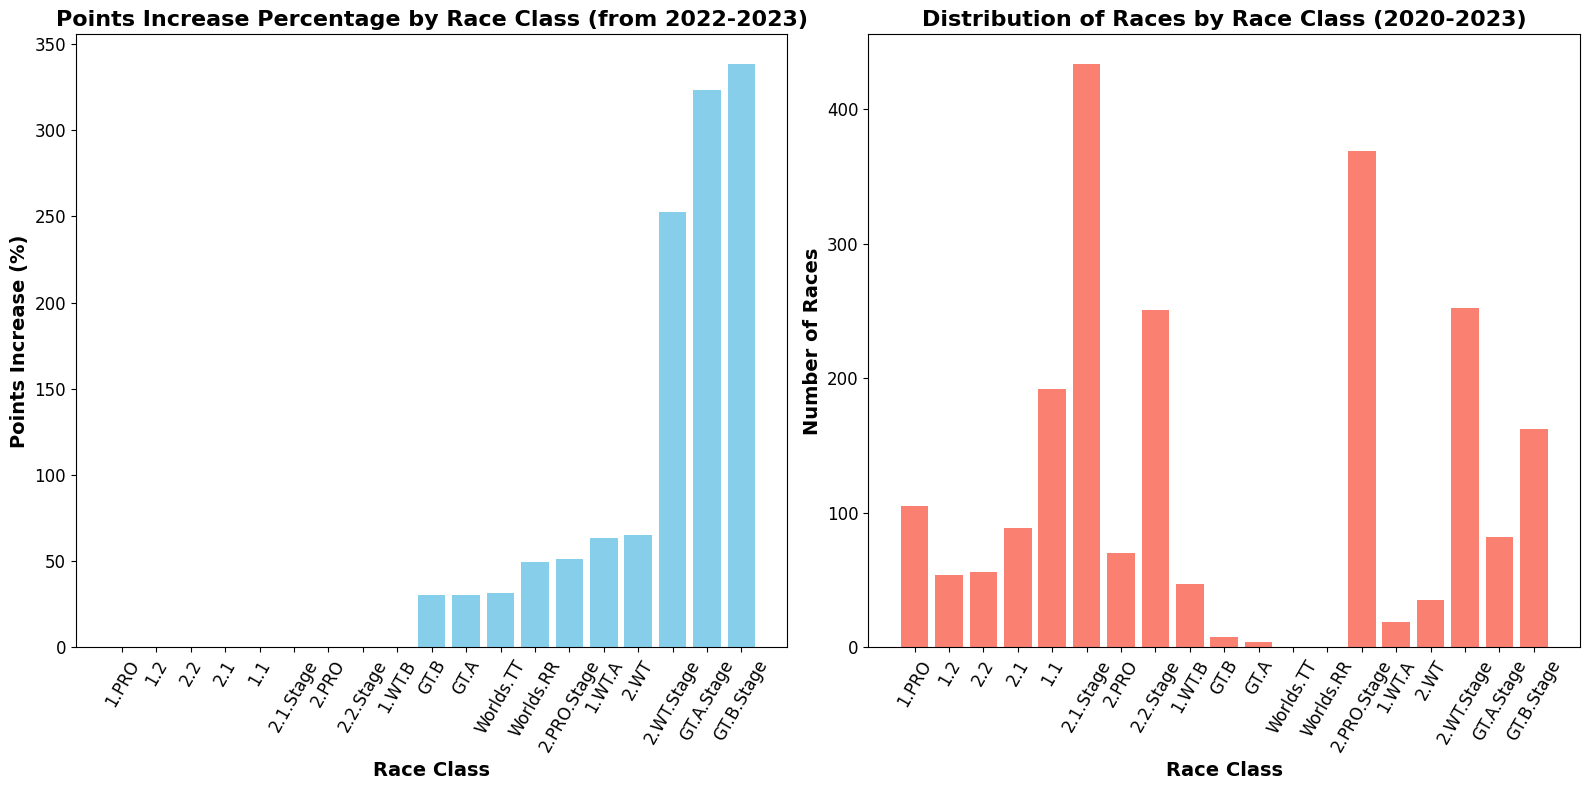

In [39]:
df_race_points = teams_riders_ranking.drop_duplicates(subset=['race', 'date'])

# Compute counts for each category.
df_race_points_counts = df_race_points.groupby('points_increase_category').size().reset_index(name='count')

scales_to_remove = []
# Sort the points_shift DataFrame by points_increase_percentage.
sorted_points_shift = points_shift.sort_values('points_increase_percentage')
ordered_scales = sorted_points_shift['pointsScale'].tolist()

# Reorder race counts according to the order in ordered_scales.
race_counts = df_race_points['pointsScale'].value_counts()
# Create an ordered Series using ordered_scales.
ordered_race_counts = race_counts.reindex(ordered_scales)

# Create a figure with two subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# --- Subplot 1: Points Increase Percentage by PointsScale ---
ax1.bar(sorted_points_shift['pointsScale'], sorted_points_shift['points_increase_percentage'], color='skyblue')
ax1.set_title("Points Increase Percentage by Race Class (from 2022-2023)", fontsize=16, fontweight='bold')
ax1.set_xlabel("Race Class", fontsize=14, fontweight='bold')
ax1.set_ylabel("Points Increase (%)", fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=60, labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# --- Subplot 2: Distribution of Races by PointsScale ---
ax2.bar(ordered_race_counts.index, ordered_race_counts.values, color='salmon')
ax2.set_title("Distribution of Races by Race Class (2020-2023)", fontsize=16, fontweight='bold')
ax2.set_xlabel("Race Class", fontsize=14, fontweight='bold')
ax2.set_ylabel("Number of Races", fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=60, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

## Rider Strategy - Star Riders vs. Distributed Effort

In [101]:
import math

def plot_feature_distributions_by_year_and_group(df, feature_list, year_col="year", group_col=None, group_order=None, bins=30):
    """
    Plots the distribution of multiple features in subplots, overlaying different years.
    If group_col is specified, it creates separate plots for each group value, 
    normalized by the number of unique teams in that group.

    Parameters:
        df (pd.DataFrame): The dataset containing the features.
        feature_list (list): A list of tuples [(feature_column, feature_label)] to plot.
        year_col (str): The column that indicates the year (default="year").
        group_col (str, optional): A categorical column to split the plots (e.g., 'budget_category').
        group_order (list, optional): Custom order for grouping values.
        bins (int): Number of bins for the histogram (default=30).
    
    Returns:
        None (Displays the subplots).
    """

    # Get unique values of group_col if provided
    group_values = group_order if group_order else (df[group_col].unique() if group_col else [None])
    
    # Determine subplot grid size
    num_features = len(feature_list)
    num_groups = len(group_values)
    total_plots = num_features * num_groups  # Total number of subplots needed
    
    num_cols = 3  # Set number of columns in subplot grid
    num_rows = math.ceil(total_plots / num_cols)  # Calculate required rows

    # Set figure size dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 6, num_rows * 5))
    axes = axes.flatten()  # Flatten in case of multiple rows

    plot_idx = 0  # Track subplot index

    # Loop through features and group values to create subplots
    for feature, feature_name in feature_list:
        for group_value in group_values:
            ax = axes[plot_idx]

            # Filter data by group_col if provided
            if group_col:
                plot_data = df[df[group_col] == group_value].copy()
            else:
                plot_data = df.copy()

            # Compute the number of unique teams per group for normalization
            num_teams = plot_data['team_gen_id'].nunique()
            
            # Plot distribution with count normalized by the number of teams
            sns.histplot(
                data=plot_data, 
                x=feature, 
                hue=year_col,  # Overlay by year
                bins=bins, 
                kde=True, 
                ax=ax, 
                palette='Set1', 
                alpha=0.5,  # Adjust transparency
                element="step",
                stat="count",  # Keep count but normalize manually
                common_norm=False,  # Prevent normalization across categories
            )

            # Normalize y-axis count by the number of teams
            if num_teams > 0:
                ax.set_yticks([tick for tick in ax.get_yticks()])
                ax.set_yticklabels([f"{tick / num_teams:.1f}" for tick in ax.get_yticks()])
                
            # Set title
            group_col_name = group_col.replace("_", " ").title() if group_col else ""
            # title = f"{feature_name} Dis" + (f" (Team's Budget: {group_value})" if group_col else "")
            title = f"{group_value} Budget" # Rider Participation Count by {feature_name} (
            ax.set_title(title, fontsize=14, fontweight='bold')
            ax.set_xlabel(feature_name, fontsize=12, fontweight='bold')
            ax.set_ylabel("Rider Participation Count per Team", fontsize=12, fontweight='bold')

            plot_idx += 1  # Move to next subplot

    # Remove empty subplots if the number of features/groups is less than the grid size
    for j in range(plot_idx, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [41]:
duplicated_teams_tours = teammates_features.loc[np.repeat(teammates_features.index, teammates_features['stages_count'].fillna(1).astype(int))].reset_index(drop=True)
duplicated_teams_tours.shape

(20018, 46)

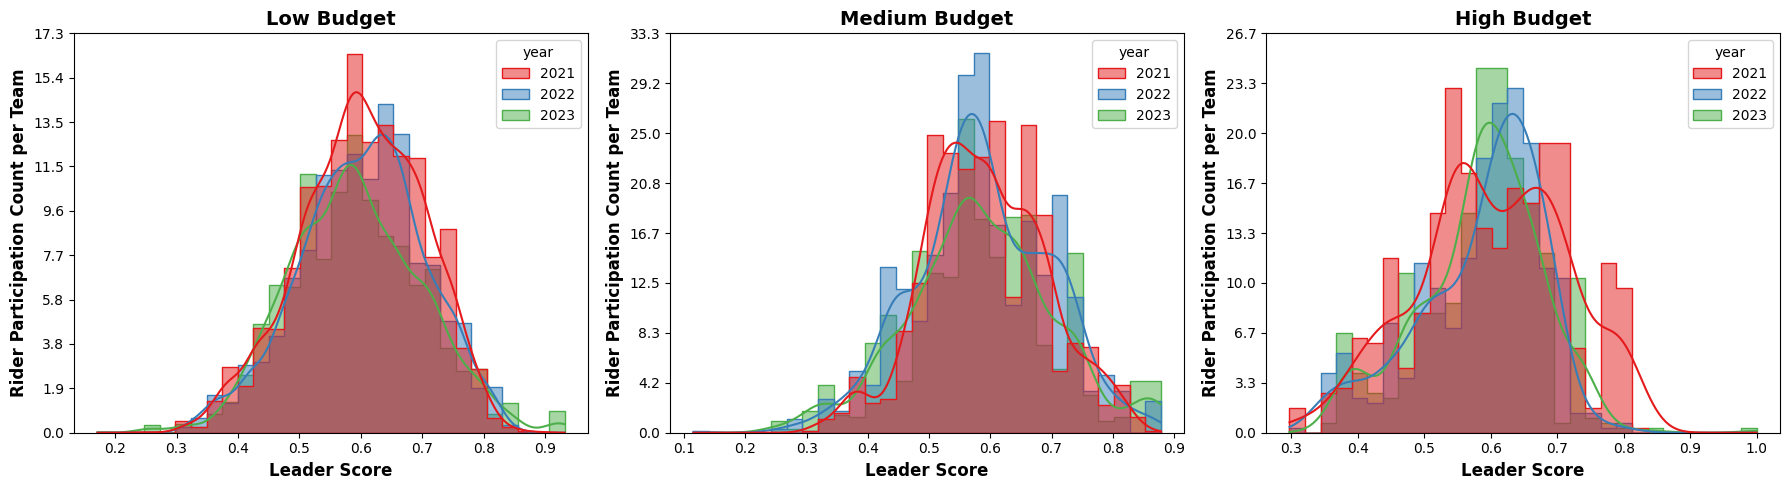

In [102]:
feature_list = [('teammates_leader_score', 'Leader Score')]

# Plot by year and race classification (each classification gets its own set of plots)
plot_feature_distributions_by_year_and_group(duplicated_teams_tours[duplicated_teams_tours['year'] > 2020], feature_list, year_col="year", group_col="budget_category", group_order=['Low', 'Medium', 'High'], bins=30)

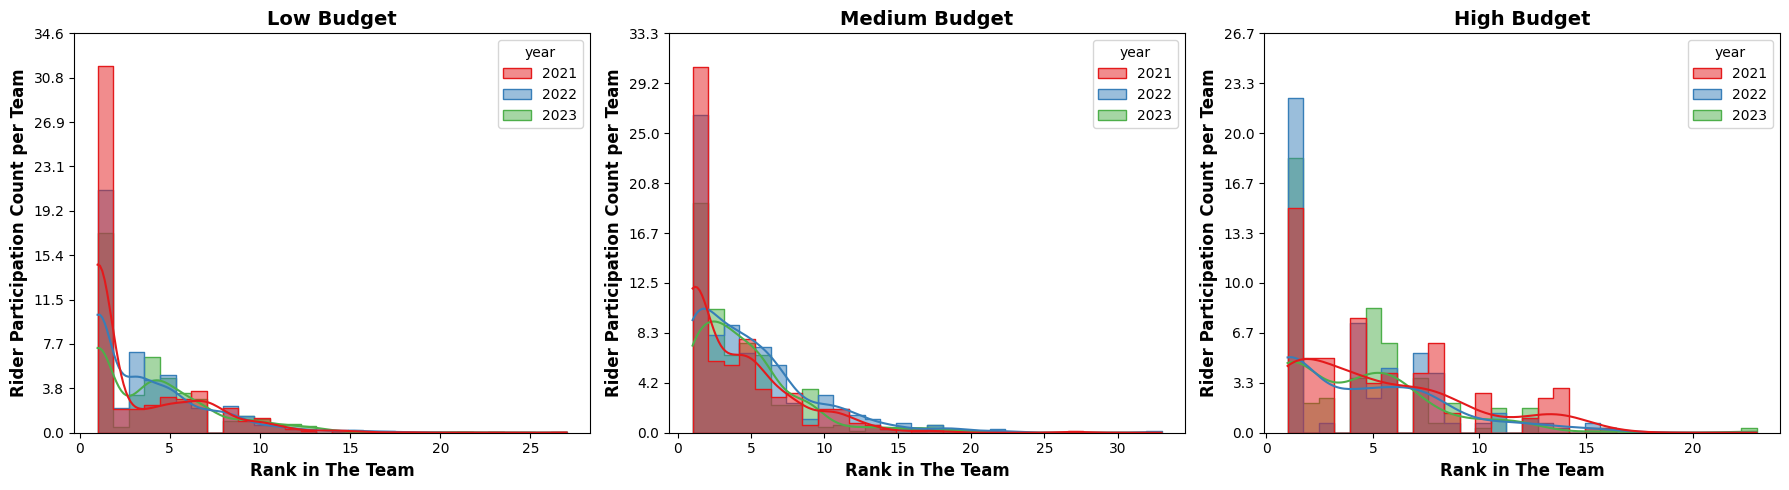

In [103]:
feature_list = [('teammates_leader_best_rank', 'Rank in The Team')]


# Plot by year and race classification (each classification gets its own set of plots)
plot_feature_distributions_by_year_and_group(teammates_features[teammates_features['year'] > 2020], feature_list, year_col="year", group_col="budget_category", group_order=['Low', 'Medium', 'High'])

## Team Rankings and Year-End Points Accumulation

In [44]:
def get_team_yearly_transitions(df):
    """
    Computes the year-to-year shift in team score and team rank for each team.
    Each row represents a single team's transition from one year to the next.

    Parameters:
        df (pd.DataFrame): DataFrame containing columns:
            - team_gen_id: Unique identifier for each team.
            - year: The year.
            - team_score: The team's score.
            - team_rank: The team's rank.
            - budget_category: Budget category of the team (e.g., Low, Medium, High).

    Returns:
        pd.DataFrame: A DataFrame showing the transition in team_score and team_rank for each team.
    """
    
    # Drop duplicates to ensure each team/year appears only once
    df_unique = df.drop_duplicates(subset=['team_gen_id', 'year']).copy()
    
    # Sort by team and year for correct shift calculations
    df_unique = df_unique.sort_values(['team_gen_id', 'year'])
    
    # Compute shifts separately for each team
    df_unique['delta_team_score'] = df_unique.groupby('team_gen_id')['team_score'].diff()
    df_unique['delta_team_rank'] = df_unique.groupby('team_gen_id')['team_rank'].diff()
    
    # Convert year to integer before creating the transition column
    df_unique['year'] = df_unique['year'].astype(int)  # Ensure years are integers

    # Shift the year column per team
    df_unique['previous_year'] = df_unique.groupby('team_gen_id')['year'].shift(1)

    # Ensure the previous year is also treated as an integer and create the transition column
    df_unique['year_transition'] = df_unique['previous_year'].fillna(0).astype(int).astype(str) + '-' + df_unique['year'].astype(str)

    # Drop NaN values (first year for each team has no previous year to compare)
    df_shift = df_unique.dropna(subset=['delta_team_score', 'delta_team_rank', 'previous_year'])

    # Select relevant columns
    df_shift = df_shift[['team_gen_id', 'team', 'team_class', 'budget_category', 'year_transition', 'team_score', 'team_rank', 'delta_team_score', 'delta_team_rank']]

    return df_shift

# Example usage: 
# Assuming your DataFrame is named df_teams and contains the required columns.
avg_shifts = get_team_yearly_transitions(teammates_features)
avg_shifts.head()

team_gen_id               team team_class budget_category year_transition  \
35       1060.0  AG2R Citroën Team         WT          Medium       2020-2021   
56       1060.0  AG2R Citroën Team         WT          Medium       2021-2022   
74       1060.0  AG2R Citroën Team         WT          Medium       2022-2023   
36       1107.0  Team Arkéa Samsic        PRT             Low       2020-2021   
23       1107.0  Team Arkéa Samsic        PRT             Low       2021-2022   

    team_score  team_rank  delta_team_score  delta_team_rank  
35      6066.0       14.0           -3580.0             -1.0  
56      9358.0       12.0            3292.0             -2.0  
74      9077.0       14.0            -281.0              2.0  
36      3628.0       21.0            1119.0             -2.0  
23      5603.0       21.0            1975.0              0.0

In [45]:
avg_shifts = avg_shifts[(avg_shifts['year_transition'] != '2021-2023') & (avg_shifts['year_transition'] != '2020-2022')]

In [46]:
def plot_team_score_shifts(df, delta_col, feature_name):
    """
    Plots a bar plot showing the delta in team score for each team over year transitions,
    colored by their Budget Category.

    Parameters:
        df (pd.DataFrame): DataFrame containing:
            - team_gen_id: Unique identifier for each team.
            - team: Team name.
            - year_transition: Year-to-year transition (e.g., "2020-2021").
            - delta_col: The change in team score.
            - Budget Category: Team's budget category for color coding.

    Returns:
        None (Displays the plot).
    """

    plt.figure(figsize=(14, 7))
    budget_order = ["Low", "Medium", "High"]

    # Create the bar plot
    sns.barplot(
        data=df,
        x="year_transition",
        y=delta_col,
        hue="budget_category",  # Color bars by budget category
        hue_order=budget_order,  # Enforce order: Low → Medium → High
        dodge=True,  # Keeps categories separated
        palette="Set1"  # Use distinct colors
    )

    # Set labels and title
    plt.xlabel("Year Transition")
    plt.ylabel(feature_name)
    plt.title(f"Yearly Change in {feature_name} by Budget Category")
    plt.xticks(rotation=45)  # Rotate x-axis labels for clarity

    # Display legend
    plt.legend(title="Budget Category")

    # Show the plot
    plt.show()

# Example usage
plot_team_score_shifts(avg_shifts, "delta_team_score", feature_name="Teams Points")

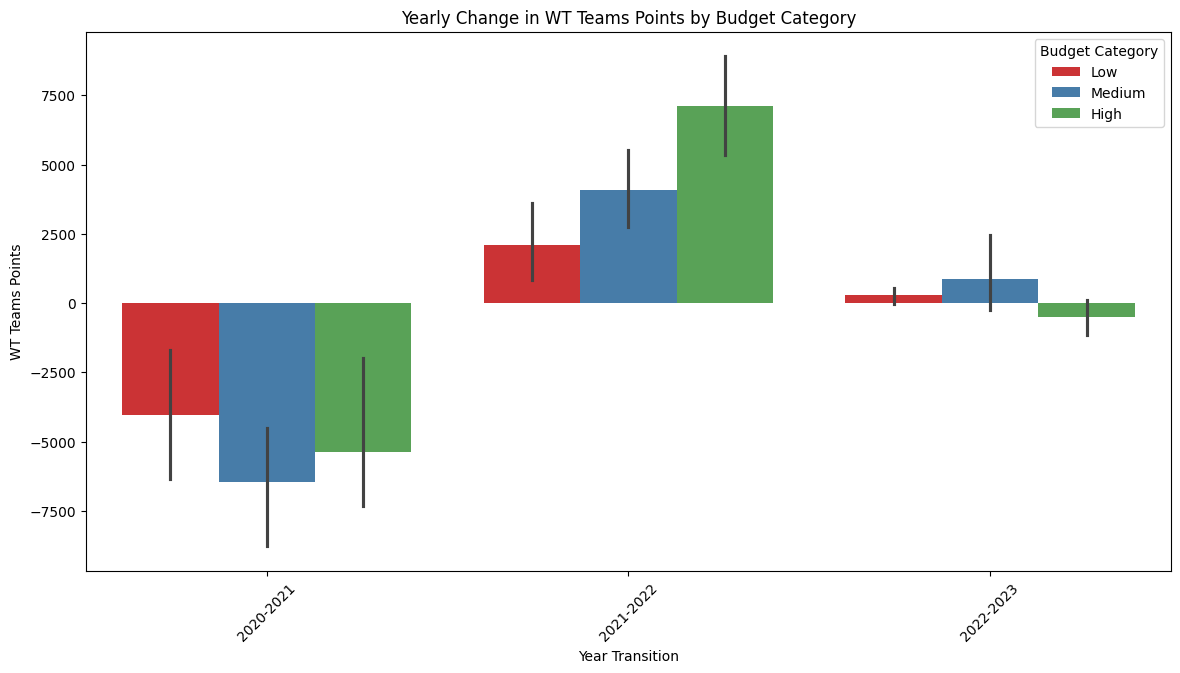

In [47]:
plot_team_score_shifts(avg_shifts[avg_shifts['team_class'] == 'WT'], "delta_team_score", feature_name="WT Teams Points")

In [48]:
plot_team_score_shifts(avg_shifts[avg_shifts['team_class'] != 'WT'], "delta_team_score", feature_name="PRT Teams Points")

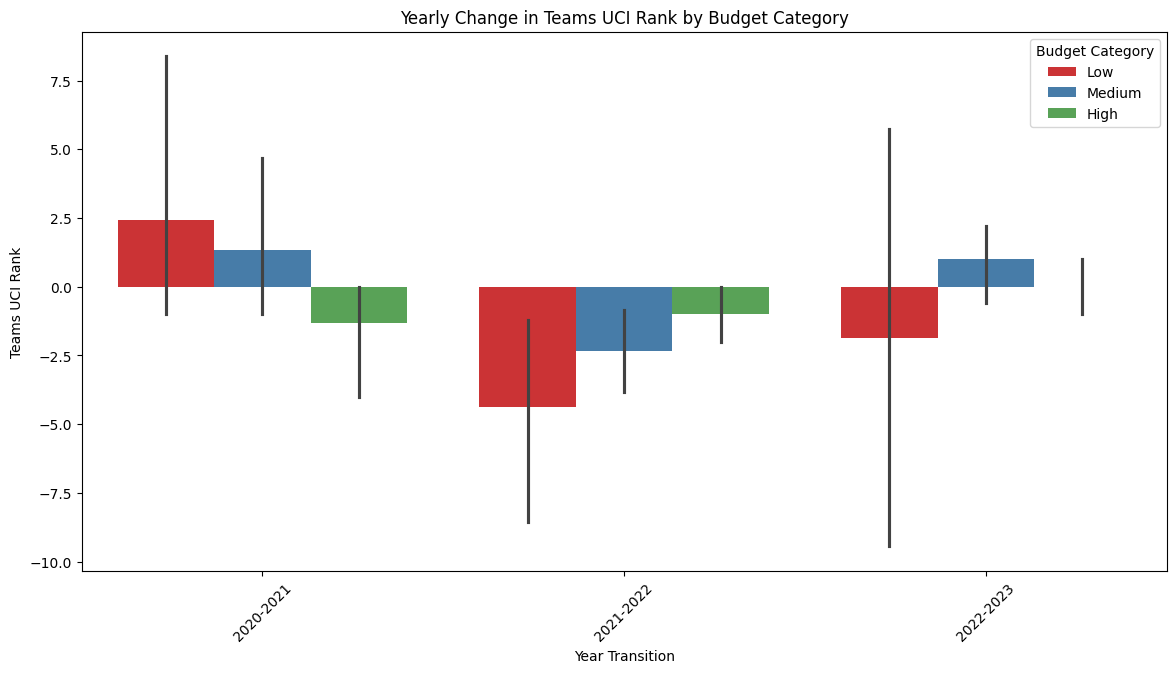

In [49]:
plot_team_score_shifts(avg_shifts, "delta_team_rank", feature_name="Teams UCI Rank")


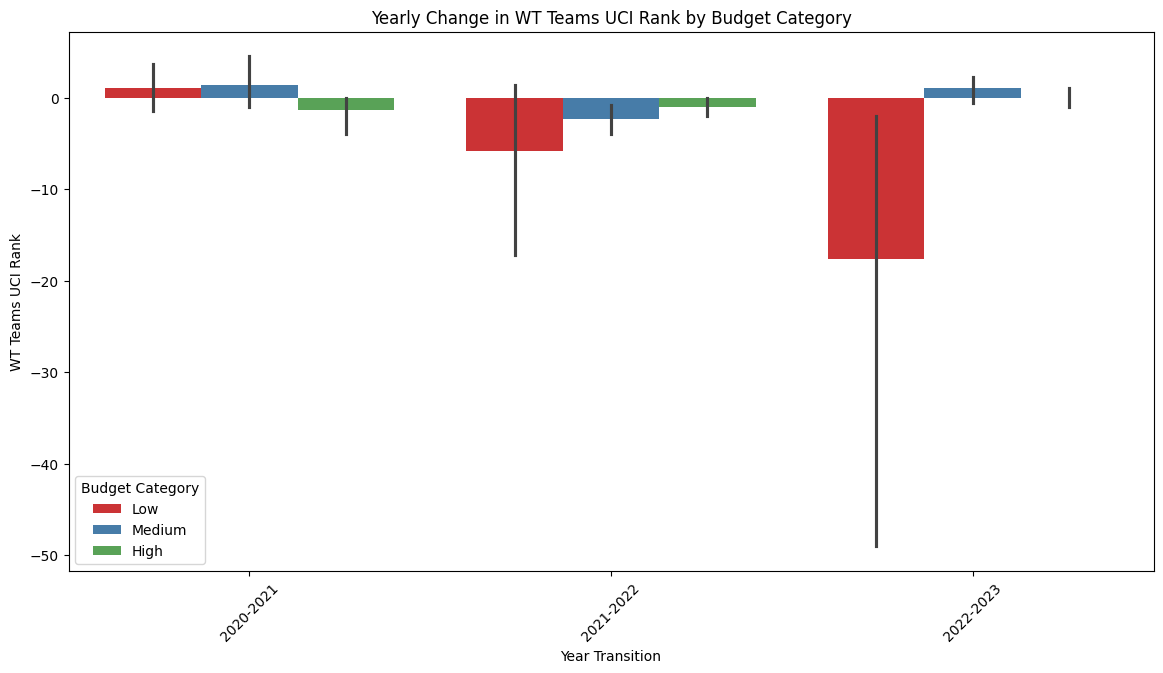

In [50]:
plot_team_score_shifts(avg_shifts[avg_shifts['team_class'] == 'WT'], "delta_team_rank", feature_name="WT Teams UCI Rank")

In [51]:
avg_shifts[avg_shifts['team_class'] == 'WT'].groupby('year_transition')['delta_team_rank'].mean()

year_transition
2020-2021    0.666667
2021-2022   -3.461538
2022-2023   -4.800000
Name: delta_team_rank, dtype: float64

In [52]:
avg_shifts[avg_shifts['team_class'] != 'WT'].groupby('year_transition')['delta_team_rank'].mean()

year_transition
2020-2021    3.000000
2021-2022   -3.846154
2022-2023    1.769231
Name: delta_team_rank, dtype: float64

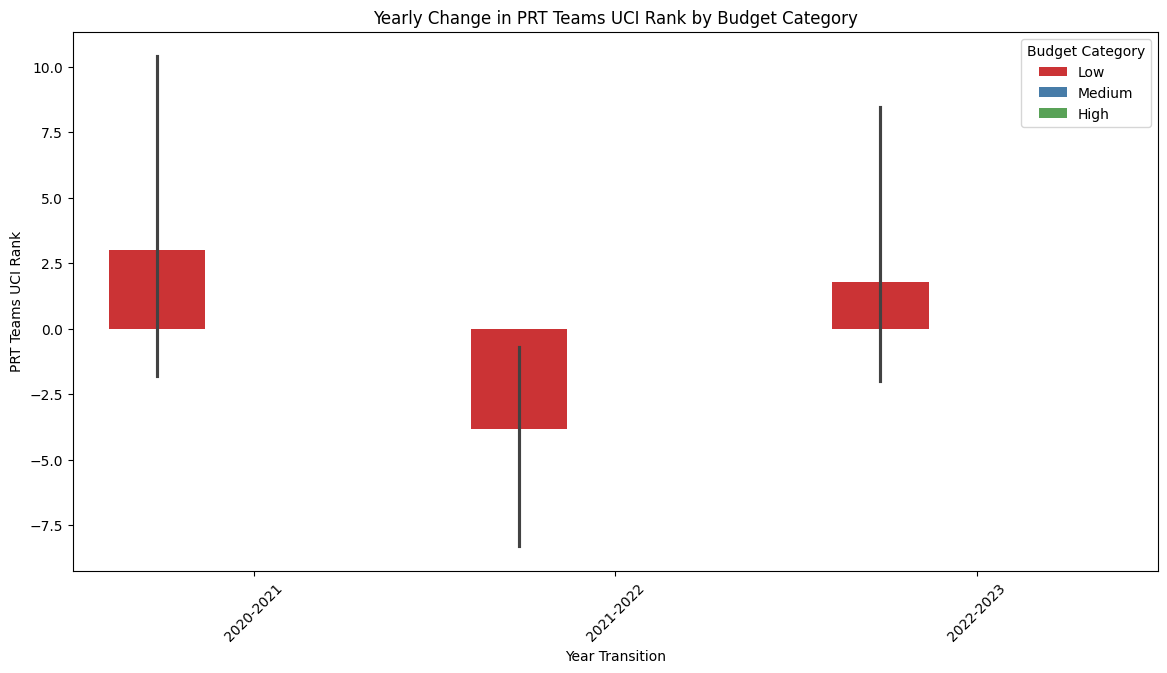

In [53]:
plot_team_score_shifts(avg_shifts[avg_shifts['team_class'] != 'WT'], "delta_team_rank", feature_name="PRT Teams UCI Rank")


## Race Participation: Shifts in Team Race Selection

In [54]:
def compute_new_team_participation_by_budget_and_classification(graphs):
    """
    For each transition from one year to the next, compute the number of new teams
    participating in races that they did not participate in the previous year.
    The new team count is grouped by the team's budget category (from team node)
    and the race's classification (from race node).
    
    Parameters:
      graphs (dict): Dictionary with years as keys and NetworkX graphs as values.
    
    Returns:
      pd.DataFrame: DataFrame with columns: 'year', 'race_classification', 
                    'budget_category', and 'new_team_count'.
    """
    new_team_records = []
    years = sorted(graphs.keys())
    
    # Define a helper to extract the set of (team, race) edges from a graph.
    def edge_set(G):
        s = set()
        for u, v in G.edges():
            # Determine which node is the team (assume team nodes have node_type 'team').
            if G.nodes[u].get('node_type') == 'team':
                team, race = u, v
            else:
                team, race = v, u
            s.add((team, race))
        return s
    
    for i, year in enumerate(years):
        if i == 0:
            # No previous year to compare with.
            continue
        G_curr = graphs[year]
        G_prev = graphs[years[i-1]]
        
        E_curr = edge_set(G_curr)
        E_prev = edge_set(G_prev)
        new_edges = E_curr - E_prev  # New team–race participations
        
        for team, race in new_edges:
            # Get team budget from the current year's graph.
            team_budget = G_curr.nodes[team].get('budget_category', 'Unknown')
            # Get race classification from the current year's graph.
            race_class = G_curr.nodes[race].get('pointsScale', 'Unknown') # pointsIncreaseCat
            race_increase_points = G_curr.nodes[race].get('pointsIncreasePer', 0)
            new_team_records.append({
                'year': year,
                'race_classification': race_class,
                'budget_category': team_budget,
                'race_increase_points': race_increase_points,
                'new_team_count': 1  # each new edge counts as one new participation
            })
    
    df_new = pd.DataFrame(new_team_records)
    if not df_new.empty:
        # Group by year, race_classification, and budget_category.
        df_grouped = df_new.groupby(['year', 'race_classification', 'budget_category']).sum().reset_index()
    else:
        df_grouped = pd.DataFrame(columns=['year', 'race_classification', 'budget_category', 'new_team_count'])
    
    return df_grouped

# Example usage:
# Assuming 'graph_by_year' is a dictionary with keys as years and corresponding NetworkX graphs.
df_new_team = compute_new_team_participation_by_budget_and_classification(graph_by_year)
df_new_team.head()


year race_classification budget_category  race_increase_points  \
0  2021                 1.1            High                   0.0   
1  2021                 1.1             Low                   0.0   
2  2021                 1.1          Medium                   0.0   
3  2021               1.PRO            High                   0.0   
4  2021               1.PRO             Low                   0.0   

   new_team_count  
0              16  
1             228  
2              39  
3              21  
4             193

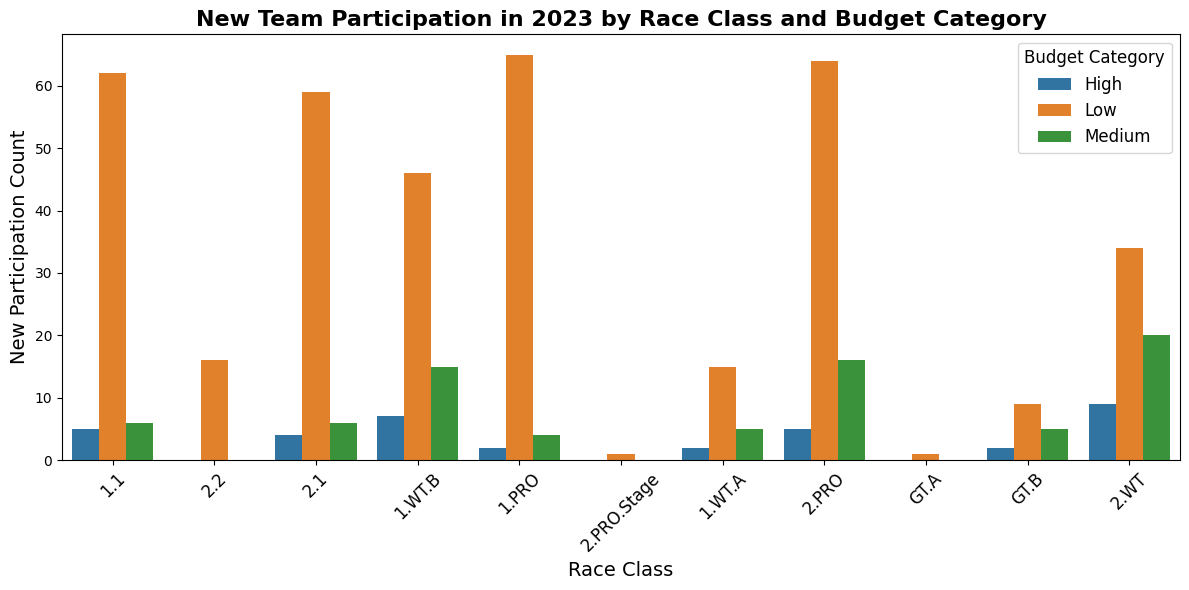

In [55]:
# Assume df_new_team is the DataFrame returned by compute_new_team_participation_by_budget_and_classification.
df_2023 = df_new_team[df_new_team['year'] == 2023]
# Sort by increate points
df_2023 = df_2023.sort_values(by=['race_increase_points'])
plt.figure(figsize=(12, 6))
sns.barplot(data=df_2023, x='race_classification', y='new_team_count', hue='budget_category')
plt.title("New Team Participation in 2023 by Race Class and Budget Category", fontsize=16, fontweight='bold')
plt.xlabel("Race Class", fontsize=14)
plt.ylabel("New Participation Count", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title="Budget Category", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.show()

In [56]:
import pycountry
import plotly.express as px

# Function to convert ISO 2-letter codes to 3-letter codes
def convert_iso2_to_iso3(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code.upper()).alpha_3
    except AttributeError:
        print(f"Country code {country_code} not found.")
        return None  # Return None if not found
    
def compute_new_team_participation(graphs):
    """
    Compute the number of new teams participating in races per country for each year.
    
    Parameters:
      graphs (dict): Dictionary with years as keys and NetworkX graphs as values.
    
    Returns:
      pd.DataFrame: DataFrame with country-wise new team counts per year.
    """
    new_team_counts = []

    # Sort years in chronological order
    years = sorted(graphs.keys())

    for i, year in enumerate(years):
        G = graphs[year]
        race_nations = {}  # Mapping race_id -> nation
        team_participation = {}  # Mapping nation -> set of new teams

        # Extract race nation information
        for node_id, attrs in G.nodes(data=True):
            if attrs['node_type'] == 'race':
                race_nations[node_id] = attrs['nation']

        # Track team participation per nation
        for team, race in G.edges():
            nation = race_nations.get(race, None)
            if nation:
                if nation not in team_participation:
                    team_participation[nation] = set()
                team_participation[nation].add(team)

        # Compute new teams per country compared to last year
        if i > 0:  # Ensure there's a previous year to compare with
            G_prev = graphs[years[i-1]]
            prev_team_participation = {}

            # Extract previous year's participation
            for team, race in G_prev.edges():
                nation = race_nations.get(race, None)
                if nation:
                    if nation not in prev_team_participation:
                        prev_team_participation[nation] = set()
                    prev_team_participation[nation].add(team)

            # Compute new teams (not in the previous year's set)
            for nation, teams in team_participation.items():
                prev_teams = prev_team_participation.get(nation, set())
                new_teams = teams - prev_teams
                new_team_counts.append({'year': year, 'nation': nation, 'new_team_count': len(new_teams)})

    return pd.DataFrame(new_team_counts)

def plot_new_team_map(new_team_df, year):
    """
    Create an interactive choropleth map using Plotly.
    """
    # Convert ISO2 to ISO3
    new_team_df["nation_iso3"] = new_team_df["nation"].apply(convert_iso2_to_iso3)

    # Filter for the given year
    year_data = new_team_df[new_team_df["year"] == year]

    # Plot
    fig = px.choropleth(
        year_data,
        locations="nation_iso3",
        color="new_team_count",
        hover_name="nation_iso3",
        color_continuous_scale="Purples",
        title=f"New Teams Participating in Races ({year})",
        projection="natural earth"
    )

    fig.show()

def plot_budget_impact_map_avg_races(aggregated_df, year):
    """
    Create a Plotly choropleth map showing the difference in average race participation
    (High-budget teams minus Low-budget teams) per nation for a given year.
    
    This function first creates a 'races_participated' column by counting the unique races
    (assumed to be represented by 'race_id') each team participated in during that year.
    
    Parameters:
      aggregated_df (pd.DataFrame): Detailed team race participation dataset containing:
                                    - 'team': Team name
                                    - 'nation': Country (ISO-2 code)
                                    - 'budget_category': e.g., "High" or "Low"
                                    - 'race_id': Unique identifier for each race
                                    - 'year': Year of participation
      year (int): Year to visualize.
    """
    
    # Create the 'races_participated' column by counting unique races per team per year
    aggregated_df["races_participated"] = aggregated_df.groupby(["team", "year"])["race_id"].transform("nunique")
    
    # Filter data for the given year and for High and Low budget categories
    year_df = aggregated_df[(aggregated_df["year"] == year) &
                            (aggregated_df["budget_category"].isin(["High", "Low"]))]
    
    # Compute average number of races participated per team by nation and budget category
    avg_races = year_df.groupby(["nation", "budget_category"])["races_participated"].mean().unstack(fill_value=0)
    
    # Compute the difference: average for High-budget teams minus average for Low-budget teams
    avg_races["Participation Difference"] = avg_races["High"] - avg_races["Low"]
    
    # Reset index for plotting
    avg_races.reset_index(inplace=True)
    
    # Convert nation codes from ISO-2 to ISO-3 using a helper function (assumed to be defined)
    avg_races["nation_iso3"] = avg_races["nation"].apply(convert_iso2_to_iso3)
    
    # Plot the choropleth map using Plotly Express
    fig = px.choropleth(
        avg_races,
        locations="nation_iso3",
        color="Participation Difference",
        hover_name="nation_iso3",
        color_continuous_scale=["red", "white", "blue"],  # Red: Low-budget dominance; Blue: High-budget dominance
        title=f"Difference in Average Race Participation (High vs. Low Budget) per Nation ({year})",
        projection="natural earth"
    )
    
    fig.show()

In [87]:
import plotly.graph_objects as go
import geopandas as gpd

def get_mode(series):
    """Return the most frequent (mode) value in a pandas series, or None if empty."""
    return series.mode()[0] if not series.mode().empty else None

def categorize_nations(aggregated_df):
    """
    Compute the average percentage increase in points per nation and categorize into High (H), Medium (M), or Low (L).
    
    Parameters:
      aggregated_df (pd.DataFrame): Dataset with `nation` and `points_increase_percentage`.
    
    Returns:
      pd.DataFrame: DataFrame with nations and their manually categorized `points_mode_label`.
    """
    # Compute average `points_increase_percentage` per nation
    nation_avg_increase = aggregated_df.groupby("nation")["points_increase_percentage"].mean().reset_index()

    # Define custom thresholds (adjust as needed)
    high_threshold = nation_avg_increase["points_increase_percentage"].quantile(0.75)  # Top 25%
    medium_threshold = nation_avg_increase["points_increase_percentage"].quantile(0.50)  # Median

    # Assign categories
    def assign_category(value):
        if value >= high_threshold:
            return "H"  # High Increase
        elif value >= medium_threshold:
            return "M"  # Medium Increase
        else:
            return "L"  # Low Increase

    nation_avg_increase["points_mode_label"] = nation_avg_increase["points_increase_percentage"].apply(assign_category)

    # Convert to ISO-3 country codes
    nation_avg_increase["nation_iso3"] = nation_avg_increase["nation"].apply(convert_iso2_to_iso3)

    return nation_avg_increase[["nation_iso3", "points_mode_label"]]
    
def plot_budget_impact_map(aggregated_df, year, shapefile_path, categorized_nations):
    """
    Create a Plotly choropleth map showing the difference in average race participation 
    (High-budget teams minus Low-budget teams) per nation.
    Ensures labels (H, M, L) are correctly placed over the main country (e.g. Metropolitan France instead of overseas territories).

    Parameters:
      aggregated_df (pd.DataFrame): Team race participation dataset with columns:
                                    - 'nation' (ISO-2 country code)
                                    - 'budget_category' (e.g., "High", "Medium", "Low")
                                    - 'race_id' (unique identifier for each race)
                                    - 'year'
                                    - (optionally) 'average_budget', 'points_increase_category', etc.
      year (int): Year to visualize.
      shapefile_path (str): Path to the shapefile with world geometries.
      categorized_nations (pd.DataFrame): DataFrame with manually categorized nations by 'points_mode_label'
      budget_threshold (str or float): "median" (default) or a specific budget value.
    """

    # --- Step 1: Create 'races_participated' column if not already present ---
    # Count unique races per team per year (assumes 'race_id' uniquely identifies each race)
    aggregated_df["races_participated"] = aggregated_df.groupby(["team", "year"])["race_id"].transform("nunique")
    
    # --- Step 2: Filter data for the given year ---
    year_df = aggregated_df[aggregated_df["year"] == year]
    
    # --- Step 3: Compute average race participation per team by nation and budget category ---
    # We focus on High and Low budget categories for the comparison.
    filtered_df = year_df[year_df["budget_category"].isin(["High", "Low"])]
    avg_races = filtered_df.groupby(["nation", "budget_category"])["races_participated"].mean().unstack(fill_value=0)
    
    # Compute the difference: average races of High-budget teams minus average races of Low-budget teams
    avg_races["Participation Count"] = avg_races["High"] - avg_races["Low"]
    
    # --- Step 4: Prepare data for plotting ---
    avg_races.reset_index(inplace=True)
    # Convert nation codes from ISO-2 to ISO-3 using a helper function (assumed to be defined elsewhere)
    avg_races["nation_iso3"] = avg_races["nation"].apply(convert_iso2_to_iso3)
    
    # Merge with the manually categorized nations so that every nation appears (with labels like H, M, L)
    full_data = categorized_nations.merge(avg_races, on="nation_iso3", how="outer")
    
    # Manually add FRA (France) if missing, ensuring the label appears for Metropolitan France
    if "FRA" not in full_data["nation_iso3"].values:
        full_data = full_data.append({"nation_iso3": "FRA", "points_mode_label": "L", "Participation Count": 0}, ignore_index=True)
    
    # Fill NaN values in Participation Count to avoid issues with Plotly
    full_data["Participation Count"] = full_data["Participation Count"].fillna(0)
    
    # Load world geometries
    world = gpd.read_file(shapefile_path)
    world = world[["geometry", "ISO_A3"]].rename(columns={"ISO_A3": "nation_iso3"})
    
    # Merge full_data with world geometries
    full_data = full_data.merge(world, on="nation_iso3", how="left")
    
    # Ensure FRA label appears over Metropolitan France (handling MultiPolygon if necessary)
    if "FRA" in full_data["nation_iso3"].values:
        fra_geometry = world.loc[world["nation_iso3"] == "FRA", "geometry"].values
        if len(fra_geometry) > 0:
            if fra_geometry[0].geom_type == "MultiPolygon":
                fra_mainland = max(fra_geometry[0], key=lambda g: g.area)
                full_data.loc[full_data["nation_iso3"] == "FRA", "geometry"] = fra_mainland
            else:
                full_data.loc[full_data["nation_iso3"] == "FRA", "geometry"] = fra_geometry[0]
    
    # Convert to GeoDataFrame to compute centroids for label placement
    full_data = gpd.GeoDataFrame(full_data, geometry="geometry")
    full_data["centroid"] = full_data.geometry.centroid
    full_data["lon"] = full_data["centroid"].apply(lambda p: p.x if p else None)
    full_data["lat"] = full_data["centroid"].apply(lambda p: p.y if p else None)
    
    # Manually adjust FRA label location if needed (using Paris coordinates as reference)
    full_data.loc[full_data["nation_iso3"] == "FRA", ["lon", "lat"]] = [2.2137, 46.6034]
    
    # Force color scale to include negative values (difference could be negative)
    min_participation = full_data["Participation Count"].min()
    max_participation = full_data["Participation Count"].max()
    
    # --- Step 5: Plot with Plotly Choropleth ---
    fig = px.choropleth(
        full_data,
        locations="nation_iso3",
        color="Participation Count",
        hover_name="nation_iso3",
        color_continuous_scale=["red", "white", "blue"],  # Red indicates dominance of Low-budget average, Blue indicates High-budget average
        title=f"Difference in Average Race Participation (High vs. Low Budget) per Nation ({year})<br>Labeled by Points Increase",
        projection="natural earth",
        labels={"Participation Count": "Participation Difference"},
        range_color=[min_participation, max_participation]
    )
    
    # Add text labels (e.g., H, M, L) at centroids with a small font size and no legend entry
    for _, row in full_data.iterrows():
        if pd.notna(row["points_mode_label"]) and pd.notna(row["lon"]) and pd.notna(row["lat"]):
            fig.add_trace(
                go.Scattergeo(
                    lon=[row["lon"]],
                    lat=[row["lat"]],
                    text=row["points_mode_label"],
                    mode="text",
                    textfont=dict(size=9, color="black", family="Arial Black"),
                    showlegend=False
                )
            )
    
    fig.show()

In [58]:
shapefile_path = f'{root_dir}/110m_cultural/ne_110m_admin_0_countries.shp'
new_team_df = compute_new_team_participation(graph_by_year)
# plot_new_team_map(new_team_df, 2023, shapefile_path)
plot_new_team_map(new_team_df, 2023)

In [88]:
teammates_features.rename(columns={'Budget Category': 'budget_category'}, inplace=True)
plot_budget_impact_map_avg_races(teammates_features, 2023)

In [89]:
categorized_nations = categorize_nations(teammates_features)  # Step 1: Categorize nations manually

plot_budget_impact_map(teammates_features, 2023, shapefile_path, categorized_nations)

C:\Users\User\AppData\Local\Temp\ipykernel_14644\4288732575.py:109: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




In [61]:
def analyze_race_participation_changes(aggregated_df):
    """
    Analyzes the difference in race participation for each team under each budget category between 2022 and 2023.
    Also analyzes the change under each `points_increase_category` (High, Medium, Low).

    Parameters:
      aggregated_df (pd.DataFrame): Dataset containing `year`, `budget_category`, `race_id`, `team_gen_id`, `points_increase_category`.

    Returns:
      None (Prints the results)
    """

    # Step 1: General Participation Changes (All Races)
    participation_per_team = aggregated_df.groupby(["year", "budget_category", "team_gen_id"])["race_id"].nunique()
    avg_races_per_team = participation_per_team.groupby(["year", "budget_category"]).mean().unstack()

    print("\n🔹 **Average Number of Races Each Team Participated in (2022 vs. 2023) (All Races):**")
    print(avg_races_per_team)

    # Compute the difference from 2022 to 2023
    if 2022 in avg_races_per_team.index and 2023 in avg_races_per_team.index:
        participation_change = avg_races_per_team.loc[2023] - avg_races_per_team.loc[2022]
        print("\n🔹 **Change in Average Races per Team (2023 - 2022) (All Races):**")
        print(participation_change)
    else:
        print("\n⚠️ Data for both 2022 and 2023 is required for comparison.")

    # Step 2: Participation Changes under each `points_increase_category`
    print("\n🔹 **Change in Race Participation per Team under each `points_increase_category` (2022 to 2023):**")
    
    for category in ["high", "medium", "low"]:
        category_df = aggregated_df[aggregated_df["points_increase_category"] == category]

        participation_per_team_category = category_df.groupby(["year", "budget_category", "team_gen_id"])["race_id"].nunique()
        avg_races_per_team_category = participation_per_team_category.groupby(["year", "budget_category"]).mean().unstack()

        print(f"\n📊 **{category} Point Increase Category:**")
        print(avg_races_per_team_category)

        # Compute the difference from 2022 to 2023
        if 2022 in avg_races_per_team_category.index and 2023 in avg_races_per_team_category.index:
            participation_change_category = avg_races_per_team_category.loc[2023] - avg_races_per_team_category.loc[2022]
            print(f"\n📉 **Change in Average Races per Team (2023 - 2022) for {category}:**")
            print(participation_change_category)
        else:
            print(f"\n⚠️ Data for both 2022 and 2023 is required for comparison in {category} category.")

# Example Usage
analyze_race_participation_changes(teammates_features)


🔹 **Average Number of Races Each Team Participated in (2022 vs. 2023) (All Races):**
budget_category       High        Low  Medium
year                                         
2020             33.000000  26.076923    37.0
2021             50.666667  46.000000    56.0
2022             61.500000  48.900000    62.5
2023             62.500000  48.111111    61.2

🔹 **Change in Average Races per Team (2023 - 2022) (All Races):**
budget_category
High      1.000000
Low      -0.788889
Medium   -1.300000
dtype: float64

🔹 **Change in Race Participation per Team under each `points_increase_category` (2022 to 2023):**

📊 **high Point Increase Category:**
budget_category  High       Low  Medium
year                                   
2020              7.0  3.285714     7.0
2021             13.0  6.368421    13.0
2022             12.0  5.000000    12.0
2023             15.0  5.437500    14.8

📉 **Change in Average Races per Team (2023 - 2022) for high:**
budget_category
High      3.0000
Low       

In [ ]:
def edge_info_df(graph):
    """
    Extract edge information from a graph, including the team budget category.
    Returns a DataFrame with columns: team, race, edge_weight, pointsIncreasePer, budget_category.
    """
    edges_data = []
    for u, v, data in graph.edges(data=True):
        # Identify team and race nodes.
        if graph.nodes[u].get('node_type') == 'team':
            team_node = u
            race_node = v
        else:
            team_node = v
            race_node = u
        # Get team budget category from the team node.
        budget_cat = graph.nodes[team_node].get('budget_category', None)
        team_class = graph.nodes[team_node].get('team_class', None)
        points_increase_category = graph.nodes[race_node].get('pointsIncreaseCat', None)
        # Get race's pointsIncreasePer attribute.
        points_increase = graph.nodes[race_node].get('pointsIncreasePer', None)
        points_scale = graph.nodes[race_node].get('pointsScale', None)  
        edges_data.append({
            'team': team_node,
            'race': race_node,
            'pointsScale': points_scale,
            'team_class': team_class,
            'edge_weight': data.get('edge_weight', None),
            'pointsIncreasePer': points_increase,
            'budget_category': budget_cat,
            'new_riders_ratio' : data.get('new_riders_count', None),
            'best_rider': data.get('best_rider', None),
            'best_rider_by_terrain': data.get('best_rider_by_terrain', None),
            'best_rider_assist': data.get('best_rider_assist', None),
            'best_rider_assist_by_terrain': data.get('best_rider_assist_by_terrain', None),
            'points_increase_category': points_increase_category,
        })
    return pd.DataFrame(edges_data)

def get_edge_set(graph):
    """Return a set of (team, race) pairs from the graph."""
    edge_set = set()
    for u, v, _ in graph.edges(data=True):
        if graph.nodes[u].get('node_type') == 'team':
            edge_set.add((u, v))
        else:
            edge_set.add((v, u))
    return edge_set

In [ ]:
# Extract edge sets from graphs of 2022 and 2023.
edges_2022 = get_edge_set(graph_by_year[2022])
edges_2023 = get_edge_set(graph_by_year[2023])

# Identify new participation: edges in 2023 that are not in 2022.
new_edges = edges_2023 - edges_2022

# Identify lost participation: edges in 2022 that are not in 2023.
lost_edges = edges_2022 - edges_2023

# Extract edge info (with budget and points increase) for new and lost participation.
df_new = edge_info_df(graph_by_year[2023])
df_new = df_new[df_new.apply(lambda r: (r['team'], r['race']) in new_edges, axis=1)]
df_new['type'] = 'new'

df_lost = edge_info_df(graph_by_year[2022])
df_lost = df_lost[df_lost.apply(lambda r: (r['team'], r['race']) in lost_edges, axis=1)]
df_lost['type'] = 'abandoned'

# Combine the two DataFrames.
df_combined = pd.concat([df_new, df_lost], ignore_index=True)
df_combined.head()

team             race pointsScale team_class  edge_weight  \
0  1107.0  1.UWT_1.WT.B_15      1.WT.B        PRT         0.53   
1  1107.0       1.1_1.1_19         1.1        PRT         0.44   
2  1107.0  1.UWT_1.WT.B_35      1.WT.B        PRT         0.62   
3  1107.0   1.Pro_1.PRO_24       1.PRO        PRT         0.53   
4  1107.0   1.UWT_1.WT.B_4      1.WT.B        PRT         0.77   

   pointsIncreasePer budget_category  new_riders_ratio  best_rider  \
0                0.0             Low               0.0         5.0   
1                0.0             Low               0.0        13.0   
2                0.0             Low               0.0         5.0   
3                0.0             Low               0.0        11.0   
4                0.0             Low               0.0         4.0   

   best_rider_by_terrain  best_rider_assist  best_rider_assist_by_terrain  \
0                    1.0                1.0                           7.0   
1                    1.0               10.0                          10.0   
2                    1.0                1.0                           4.0   
3                    1.0                8.0                           1.0   
4                    1.0                2.0                           1.0   

  points_increase_category type  
0                      low  new  
1                      low  new  
2                      low  new  
3                      low  new  
4                      low  new

In [ ]:
df_combined['team_class'].value_counts()

team_class
WT     644
PRT    505
Name: count, dtype: int64

In [ ]:
# First, group the combined DataFrame by budget_category, participation type, and pointsIncreasePer.
# We round the pointsIncreasePer slightly (e.g., to one decimal) to aggregate if there are minor fluctuations.
df_counts = df_combined[df_combined['team_class'] == 'WT'].copy()
df_counts['pointsIncreaseRounded'] = df_counts['pointsIncreasePer'].round(1)
df_counts = df_counts.groupby(['budget_category', 'type', 'pointsIncreaseRounded']).size().reset_index(name='count')

budget_categories = ["Low", "Medium", "High"]

# Create one subplot per budget category.
fig, axes = plt.subplots(1, len(budget_categories), figsize=(18, 6), sharey=True)

for i, cat in enumerate(budget_categories):
    df_cat = df_counts[df_counts['budget_category'] == cat]
    # Plot a line plot (or scatter+line) showing count vs. points increase.
    sns.lineplot(x='pointsIncreaseRounded', y='count', hue='type', marker='o', data=df_cat, ax=axes[i])
    axes[i].set_title(f"Budget: {cat.capitalize()}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Race Points Increase (%)", fontsize=12, fontweight='bold')
    axes[i].set_ylabel("Participation Count", fontsize=12, fontweight='bold')
    axes[i].xlim = (0, 350)
    if i == 0:
        axes[i].set_ylabel("Participation Count")
    axes[i].axhline(0, color='gray', linestyle='--')
    axes[i].legend(title="Participation Type")
    
plt.suptitle("New vs. abandoned Races Participation Count vs. Race Points Increase\nby Team Budget Category")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Roster Allocation: Strengthening Race Participation Strategies

In [62]:
def plot_edge_weight_distribution(G, year='2023'):
    # Collect data for each edge: race's pointsScale and edge_weight
    edge_data = []
    for u, v, data in G.edges(data=True):
        # Determine which node is a race node.
        if G.nodes[u].get('node_type') == 'race':
            race_node = u
        elif G.nodes[v].get('node_type') == 'race':
            race_node = v
        else:
            continue
        points_scale = G.nodes[race_node].get('classification', None)
        edge_weight = data.get('edge_weight', None)
        if points_scale is not None and edge_weight is not None:
            edge_data.append({'classification': points_scale, 'edge_weight': edge_weight})
    
    # Create a DataFrame with the collected data.
    df_edges = pd.DataFrame(edge_data)
    
    # Plot the distribution grouped by pointsScale using a boxplot (you could also use a violin plot)
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='classification', y='edge_weight', data=df_edges)
    plt.title(f'Edge Weight Distribution by Race PointsScale for {year}')
    plt.xlabel('Race PointsScale')
    plt.ylabel('Edge Weight')
    plt.show()

def plot_edge_weight_distribution_by_budget(G, year='2023'):
    """
    Extract edge information from graph G, including:
      - Race's classification (from the race node)
      - Edge weight
      - Team's budget category (from the team node)
    
    Then create a faceted boxplot showing the edge weight distribution by race classification,
    with one subplot per team budget category (ordered as Low, Medium, High).
    
    Parameters:
      G (networkx.Graph): Graph for the specified year.
      year (str): Year label for the title.
    """
    edge_data = []
    for u, v, data in G.edges(data=True):
        # Identify team and race nodes based on node type.
        if G.nodes[u].get('node_type') == 'team':
            team_node = u
            race_node = v
        elif G.nodes[v].get('node_type') == 'team':
            team_node = v
            race_node = u
        else:
            continue
        
        classification = G.nodes[race_node].get('pointsScale', None)
        edge_weight = data.get('edge_weight', None)
        budget_category = G.nodes[team_node].get('budget_category', None)
        
        if classification is not None and edge_weight is not None and budget_category is not None:
            edge_data.append({
                'pointsScale': classification,
                'edge_weight': edge_weight,
                'budget_category': budget_category
            })
    
    # Create a DataFrame from the collected edge data.
    df_edges = pd.DataFrame(edge_data)
    
    # Create a faceted boxplot by team budget category.
    g = sns.catplot(
        x='pointsScale',
        y='edge_weight',
        col='budget_category',
        data=df_edges,
        kind='box',
        col_order=["Low", "Medium", "High"],
        height=6,
        aspect=0.8,
        palette='Set2'
    )
    
    g.set_axis_labels("Race pointsScale", "Edge Weight")
    g.fig.suptitle(f'Edge Weight Distribution by Race pointsScale\nby Team Budget Category for {year}', y=1.05)
    # rotate x-axis labels for better readability
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment('right')
    plt.show()

In [63]:
year_to_visualize = 2023
G_year = graph_by_year[year_to_visualize]
plot_edge_weight_distribution(G_year)
plot_edge_weight_distribution(graph_by_year[2022], year='2022')

C:\Users\User\AppData\Local\Temp\ipykernel_14644\3406510672.py:69: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




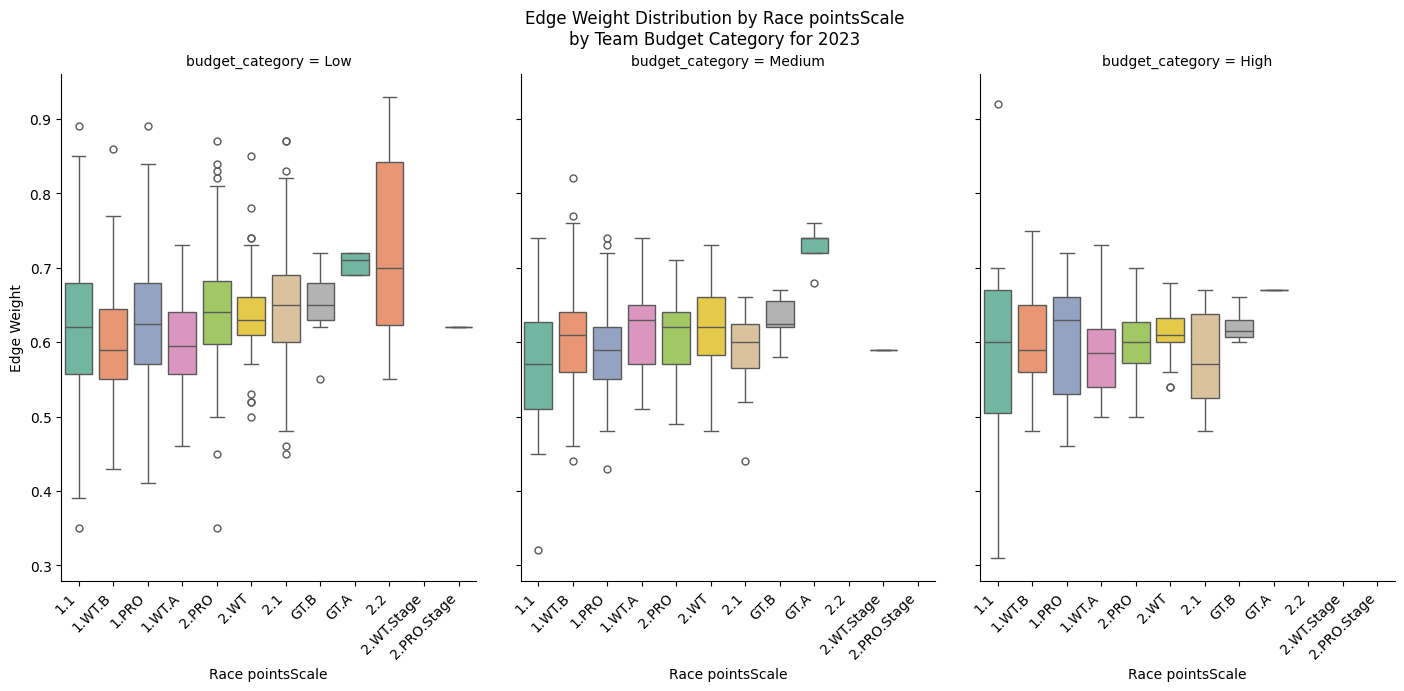

C:\Users\User\AppData\Local\Temp\ipykernel_14644\3406510672.py:69: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




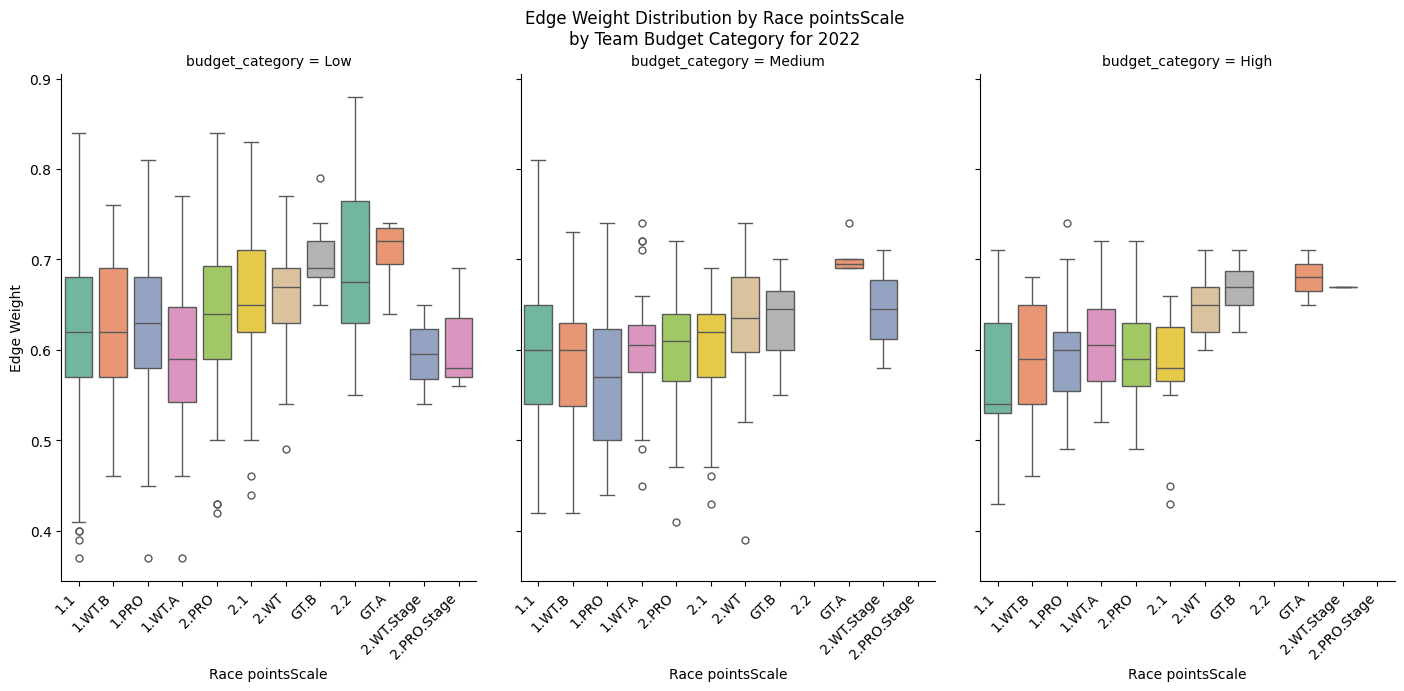

In [64]:
plot_edge_weight_distribution_by_budget(graph_by_year[2023], year='2023')
plot_edge_weight_distribution_by_budget(graph_by_year[2022], year='2022')

In [65]:
def extract_edges_with_budget(graph):
    """
    Extract edge information from a graph, including the team budget category.
    Returns a DataFrame with columns: team, race, edge_weight, pointsIncreasePer, budget_category.
    """
    edges_data = []
    for u, v, data in graph.edges(data=True):
        # Identify which node is the team and which is the race.
        if graph.nodes[u].get('node_type') == 'team':
            team_node = u
            race_node = v
        else:
            team_node = v
            race_node = u
        # Get team budget category from the team node.
        budget_cat = graph.nodes[team_node].get('budget_category', None)
        # Get race's pointsIncreasePer attribute.
        points_increase = graph.nodes[race_node].get('pointsIncreasePer', None)
        edges_data.append({
            'team': team_node,
            'race': race_node,
            'edge_weight': data.get('edge_weight', None),
            'pointsIncreasePer': points_increase,
            'budget_category': budget_cat
        })
    return pd.DataFrame(edges_data)

def compare_edge_weights(graphs, year1, year2):
    """
    For the two given years (e.g., 2022 and 2023), extract edge information (including budget category)
    from the corresponding graphs, merge them on the (team, race) pairs, and compute the delta edge weight.
    """
    df1 = extract_edges_with_budget(graphs[year1])
    df2 = extract_edges_with_budget(graphs[year2])
    
    # Merge on the common team and race identifiers.
    merged = pd.merge(df1, df2, on=['team', 'race'], suffixes=(f'_{year1}', f'_{year2}'))
    merged['delta_edge_weight'] = merged[f'edge_weight_{year2}'] - merged[f'edge_weight_{year1}']
    # We'll assume budget_category remains the same across years; take it from year2.
    merged['budget_category'] = merged[f'budget_category_{year2}']
    # Also use pointsIncreasePer from year2.
    merged['pointsIncreasePer'] = merged[f'pointsIncreasePer_{year2}']
    return merged

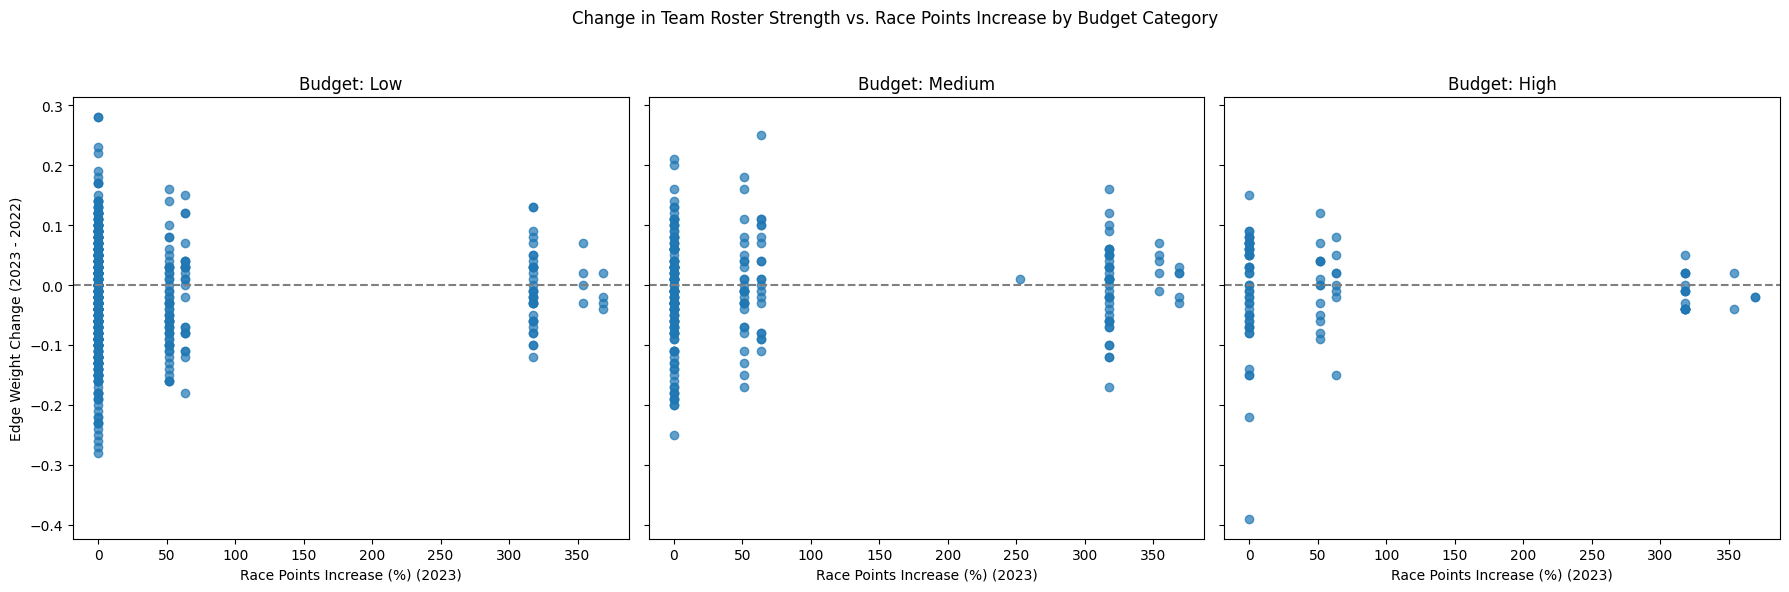

In [66]:
df_diff = compare_edge_weights(graph_by_year, 2022, 2023)

# Now, create subplots for each budget category.
budget_categories = ['low', 'medium', 'high']  # Adjust these strings to match your actual budget_category values.
fig, axes = plt.subplots(1, 3, figsize=(18,6), sharey=True)

for i, cat in enumerate(budget_categories):
    df_cat = df_diff[df_diff['budget_category'].str.lower() == cat]
    axes[i].scatter(df_cat['pointsIncreasePer'], df_cat['delta_edge_weight'], alpha=0.7)
    axes[i].set_title(f"Budget: {cat.capitalize()}")
    axes[i].set_xlabel("Race Points Increase (%) (2023)")
    if i == 0:
        axes[i].set_ylabel("Edge Weight Change (2023 - 2022)")
    axes[i].axhline(0, color='gray', linestyle='--')

fig.suptitle("Change in Team Roster Strength vs. Race Points Increase by Budget Category")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [71]:
def plot_metric_change(df_common, metric_col, y_label, suptitle, budget_categories=["Low", "Medium", "High"]):
    """
    Create scatter subplots (one per budget category) of a change metric versus race points increase.
    
    Parameters:
      df_common (pd.DataFrame): DataFrame with merged edge information for common (team, race) pairs.
          Must include columns:
            - 'pointsIncreasePer' (from 2023)
            - 'budget_category' (e.g., "Low", "Medium", "High")
            - The change metric column (e.g., 'delta_best_rider')
      metric_col (str): Column name in df_common representing the change metric to plot.
      y_label (str): Label for the y-axis.
      suptitle (str): Overall title for the plot.
      budget_categories (list): List of budget categories in the order they should appear.
      
    Returns:
      None: Displays the plot.
    """
    # Create subplots: one per budget category.
    fig, axes = plt.subplots(1, len(budget_categories), figsize=(6 * len(budget_categories), 6), sharey=True)
    
    for i, cat in enumerate(budget_categories):
        # Filter for current budget category (case-insensitive).
        df_cat = df_common[df_common['budget_category'].str.lower() == cat.lower()]
        sns.scatterplot(x='pointsIncreasePer', y=metric_col, data=df_cat, ax=axes[i])
        axes[i].set_title(f"Budget: {cat}")
        axes[i].set_xlabel("Race Points Increase (%) (2023)")
        if i == 0:
            axes[i].set_ylabel(y_label)
        axes[i].axhline(0, color='gray', linestyle='--')
    
    fig.suptitle(suptitle, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

def plot_delta_metric_by_points_bin(df, metric_col, y_label, suptitle,
                                  points_bin_col='points_increase_bin',
                                  budget_col='budget_category_2023',
                                  col_order=["Low", "Medium", "High"],
                                  height=6, aspect=0.8, palette='Set2'):
  """
  Create strip plots of a delta metric versus discretized points increase categories,
  with one subplot per team budget category.
  
  Parameters:
    df (pd.DataFrame): DataFrame containing the merged edge data with the following columns:
        - points_bin_col: discretized points increase category (e.g., "Low", "Medium", "High")
        - metric_col: the delta metric to plot (e.g., 'delta_new_riders_ratio')
        - budget_col: column name for the team budget category (default 'budget_category_2023')
    y_label (str): Label for the y-axis.
    suptitle (str): Overall title for the plot.
    points_bin_col (str): Column name with discretized points increase categories.
    budget_col (str): Column name for team budget category.
    col_order (list): Order for budget categories to appear from left to right.
    height (int): Height for each subplot.
    aspect (float): Aspect ratio for each subplot.
    palette (str): Color palette to use.
  
  Returns:
    None: Displays the plot.
  """
  g = sns.catplot(
      x=points_bin_col, 
      y=metric_col, 
      col=budget_col, 
      data=df, 
      kind='strip',
      height=height, 
      aspect=aspect,
      jitter=True, 
      palette=palette,
      col_order=col_order
  )
  
  g.set_axis_labels("Race Points Increase Category", y_label)
  g.fig.suptitle(suptitle, y=1.08)
  plt.show()

In [72]:
def compute_edge_deltas(graphs, year1=2022, year2=2023):
    # Get common edges between year1 and year2.
    edges_y1 = get_edge_set(graphs[year1])
    edges_y2 = get_edge_set(graphs[year2])
    common_edges = edges_y1.intersection(edges_y2)
    
    # Extract edge info for each year and filter to common edges.
    df_y1 = edge_info_df(graphs[year1])
    df_y1 = df_y1[df_y1.apply(lambda r: (r['team'], r['race']) in common_edges, axis=1)]
    df_y1 = df_y1.rename(columns={
        'new_riders_ratio': f'new_riders_ratio_{year1}',
        'best_rider': f'best_rider_{year1}',
        'best_rider_by_terrain': f'best_rider_by_terrain_{year1}',
        'best_rider_assist': f'best_rider_assist_{year1}',
        'best_rider_assist_by_terrain': f'best_rider_assist_by_terrain_{year1}',
        'edge_weight': f'edge_weight_{year1}',
        'pointsIncreasePer': f'pointsIncreasePer_{year1}',
        'pointsScale': f'pointsScale_{year1}',
        'budget_category': f'budget_category_{year1}',
        'points_increase_category': f'points_increase_category_{year1}'
    })
    
    df_y2 = edge_info_df(graphs[year2])
    df_y2 = df_y2[df_y2.apply(lambda r: (r['team'], r['race']) in common_edges, axis=1)]
    df_y2 = df_y2.rename(columns={
        'new_riders_ratio': f'new_riders_ratio_{year2}',
        'best_rider': f'best_rider_{year2}',
        'best_rider_by_terrain': f'best_rider_by_terrain_{year2}',
        'best_rider_assist': f'best_rider_assist_{year2}',
        'best_rider_assist_by_terrain': f'best_rider_assist_by_terrain_{year2}',
        'edge_weight': f'edge_weight_{year2}',
        'pointsIncreasePer': f'pointsIncreasePer_{year2}',
        'pointsScale': f'pointsScale_{year2}',
        'budget_category': f'budget_category_{year2}',
        'points_increase_category': f'points_increase_category_{year2}'
    })
    
    # Merge on team and race.
    df_common = pd.merge(df_y1, df_y2, on=['team', 'race'])
    
    # Define the numeric attributes to compute deltas for.
    numeric_attrs = ['new_riders_ratio', 'best_rider', 'best_rider_by_terrain',
                     'best_rider_assist', 'best_rider_assist_by_terrain', 'edge_weight', 'pointsIncreasePer']
    
    for attr in numeric_attrs:
        col_y1 = f'{attr}_{year1}'
        col_y2 = f'{attr}_{year2}'
        df_common[f'delta_{attr}'] = df_common[col_y2] - df_common[col_y1]
    
    # Also retain static fields: team, race, pointsScale and budget_category (from year2)
    df_common['pointsScale'] = df_common[f'pointsScale_{year2}']
    df_common['budget_category'] = df_common[f'budget_category_{year2}']
    df_common['pointsIncreasePer'] = df_common[f'pointsIncreasePer_{year2}']
    df_common['points_increase_category'] = df_common[f'points_increase_category_{year2}']
    
    return df_common

# Assuming graph_by_year is a dictionary of graphs keyed by year.
df_deltas = compute_edge_deltas(graph_by_year, year1=2022, year2=2023)
df_deltas.head()

team             race pointsScale_2022 team_class_x  edge_weight_2022  \
0  1107.0       1.1_1.1_10              1.1          PRT              0.47   
1  1107.0  1.UWT_1.WT.B_33           1.WT.B          PRT              0.59   
2  1107.0       1.1_1.1_40              1.1          PRT              0.57   
3  1107.0       1.1_1.1_20              1.1          PRT              0.47   
4  1107.0   1.Pro_1.PRO_11            1.PRO          PRT              0.45   

   pointsIncreasePer_2022 budget_category_2022  new_riders_ratio_2022  \
0                     0.0                  Low                    0.0   
1                     0.0                  Low                    0.0   
2                     0.0                  Low                    0.0   
3                     0.0                  Low                    0.0   
4                     0.0                  Low                    0.0   

   best_rider_2022  best_rider_by_terrain_2022  ...  delta_best_rider  \
0              4.0                         1.0  ...               0.0   
1              4.0                         1.0  ...              -1.0   
2              9.0                        12.0  ...              -6.0   
3              9.0                         1.0  ...              -8.0   
4              6.0                         9.0  ...               0.0   

   delta_best_rider_by_terrain delta_best_rider_assist  \
0                          0.0                    -4.0   
1                          7.0                    -3.0   
2                         -4.0                    -6.0   
3                          0.0                    -5.0   
4                         -8.0                     2.0   

  delta_best_rider_assist_by_terrain delta_edge_weight  \
0                               -1.0              0.08   
1                               -4.0             -0.03   
2                               -8.0             -0.01   
3                                5.0              0.05   
4                                2.0             -0.01   

   delta_pointsIncreasePer  pointsScale budget_category  pointsIncreasePer  \
0                      0.0          1.1             Low                0.0   
1                      0.0       1.WT.B             Low                0.0   
2                      0.0          1.1             Low                0.0   
3                      0.0          1.1             Low                0.0   
4                      0.0        1.PRO             Low                0.0   

   points_increase_category  
0                       low  
1                       low  
2                       low  
3                       low  
4                       low  

[5 rows x 35 columns]

In [73]:
delta_cols = [col for col in df_deltas.columns if col.startswith('delta_')]
delta_cols

['delta_new_riders_ratio',
 'delta_best_rider',
 'delta_best_rider_by_terrain',
 'delta_best_rider_assist',
 'delta_best_rider_assist_by_terrain',
 'delta_edge_weight',
 'delta_pointsIncreasePer']

In [74]:
df_deltas.groupby(['budget_category', 'points_increase_category'])[[
 'delta_best_rider_by_terrain',
 'delta_best_rider_assist_by_terrain',
 'delta_edge_weight']].describe()

delta_best_rider_by_terrain  \
                                                               count   
budget_category points_increase_category                               
High            high                                            19.0   
                low                                             49.0   
                medium                                          21.0   
Low             high                                            43.0   
                low                                            370.0   
                medium                                          81.0   
Medium          high                                            49.0   
                low                                            130.0   
                medium                                          50.0   

                                                                         \
                                              mean       std        min   
budget_category points_increase_category                                  
High            high                     -0.184704  1.486123  -5.285714   
                low                       0.959184  4.627631 -12.000000   
                medium                   -0.711640  3.330954 -10.000000   
Low             high                     -0.292468  1.734313  -4.625000   
                low                      -0.053739  3.684942 -29.000000   
                medium                    0.108564  4.265650 -13.000000   
Medium          high                     -0.007491  2.366604  -6.625000   
                low                      -0.129670  4.423082 -19.000000   
                medium                    0.290000  3.287331 -11.000000   

                                                                              \
                                               25%  50%       75%        max   
budget_category points_increase_category                                       
High            high                      0.000000  0.0  0.000000   2.142857   
                low                       0.000000  0.0  0.000000  19.000000   
                medium                   -1.333333  0.0  0.000000   5.000000   
Low             high                     -0.661616  0.0  0.000000   3.571429   
                low                       0.000000  0.0  0.000000  13.000000   
                medium                    0.000000  0.0  0.888889  17.000000   
Medium          high                     -1.142857  0.0  1.000000   6.857143   
                low                       0.000000  0.0  0.000000  14.000000   
                medium                    0.000000  0.0  1.166667   7.333333   

                                         delta_best_rider_assist_by_terrain  \
                                                                      count   
budget_category points_increase_category                                      
High            high                                                   19.0   
                low                                                    49.0   
                medium                                                 21.0   
Low             high                                                   43.0   
                low                                                   370.0   
                medium                                                 81.0   
Medium          high                                                   49.0   
                low                                                   130.0   
                medium                                                 50.0   

                                                    ...                       \
                                              mean  ...       75%        max   
budget_category points_increase_category            ...                        
High            high                     -1.027797  ...  0.352814   3.523810   
                low                      -0.5

In [75]:
# Define the bins and labels
bins = [0, 50, 200, np.inf]
labels = ["Low", "Medium", "High"]

# Assuming df_deltas is your combined delta DataFrame and that 'pointsIncreasePer' is numeric:
df_deltas['points_increase_bin'] = pd.cut(df_deltas['pointsIncreasePer'], bins=bins, labels=labels, right=False)

# Alternatively, using np.select:
conditions = [
    df_deltas['pointsIncreasePer'] < 50,
    (df_deltas['pointsIncreasePer'] >= 50) & (df_deltas['pointsIncreasePer'] < 200),
    df_deltas['pointsIncreasePer'] >= 200
]
choices = ["Low", "Medium", "High"]
df_deltas['points_increase_bin'] = np.select(conditions, choices, default="Unknown")
df_deltas['points_increase_bin'].value_counts()


points_increase_bin
Low       549
Medium    152
High      111
Name: count, dtype: int64

In [76]:
df_deltas['budget_category'].value_counts()

budget_category
Low       494
Medium    229
High       89
Name: count, dtype: int64

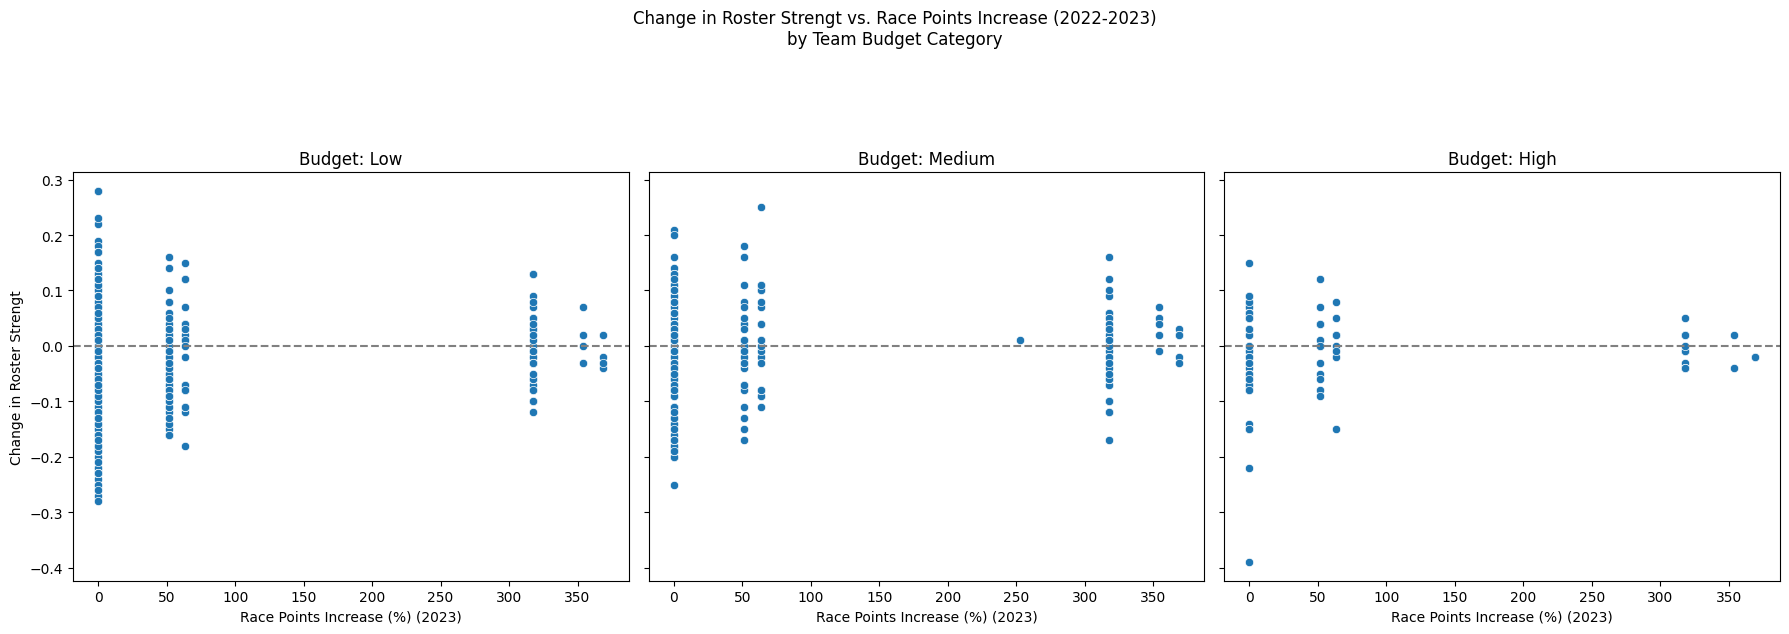

In [ ]:
plot_metric_change(df_deltas, 
                   metric_col='delta_edge_weight', 
                   y_label="Change in Roster Strength",
                   suptitle="Change in Roster Strengt vs. Race Points Increase (2022-2023)\nby Team Budget Category")


In [78]:
plot_delta_metric_by_points_bin(
    df_deltas,
    metric_col='delta_new_riders_ratio',
    y_label="Delta New Riders Ratio (2023 - 2022)",
    suptitle="Change in New Riders Ratio vs. Race Points Increase\nby Team Budget Category"
)

C:\Users\User\AppData\Local\Temp\ipykernel_14644\289964932.py:62: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




C:\Users\User\AppData\Local\Temp\ipykernel_14644\1421175764.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




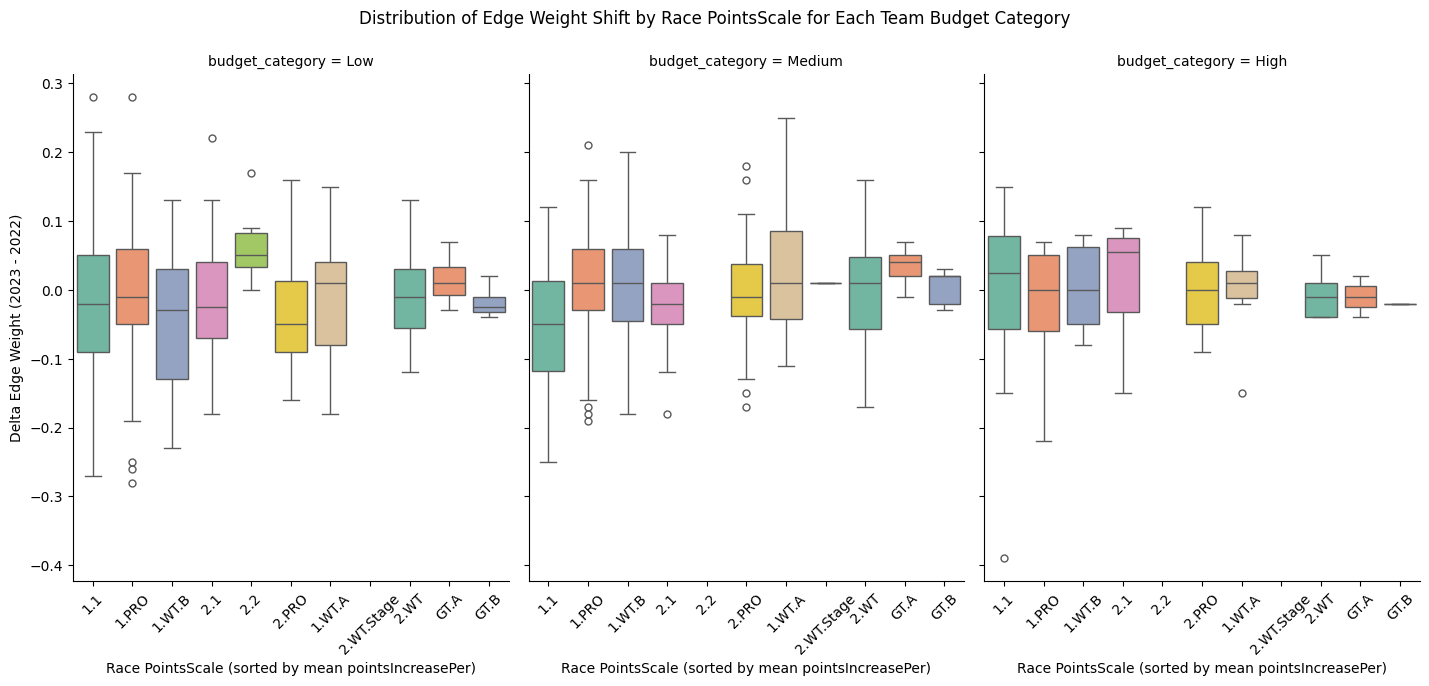

In [81]:
order_df = df_deltas.groupby('pointsScale', as_index=False)['pointsIncreasePer'].mean()
# Sort by the mean pointsIncreasePer
order_df = order_df.sort_values('pointsIncreasePer')
sorted_order = order_df['pointsScale'].tolist()

# Create a faceted boxplot by budget category.
g = sns.catplot(
    x='pointsScale',
    y='delta_edge_weight',
    col='budget_category',
    data=df_deltas,
    kind='box',
    col_order=["Low", "Medium", "High"],
    order=sorted_order,  # use the sorted order based on pointsIncreasePer
    height=6,
    aspect=0.8,
    palette='Set2'
)

g.set_axis_labels("Race PointsScale (sorted by mean pointsIncreasePer)", "Delta Edge Weight (2023 - 2022)")
g.fig.suptitle("Distribution of Edge Weight Shift by Race PointsScale for Each Team Budget Category", y=1.05)

# Rotate the x tick labels for clarity.
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_14644\2103816713.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\User\AppData\Local\Temp\ipykernel_14644\2103816713.py:7: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




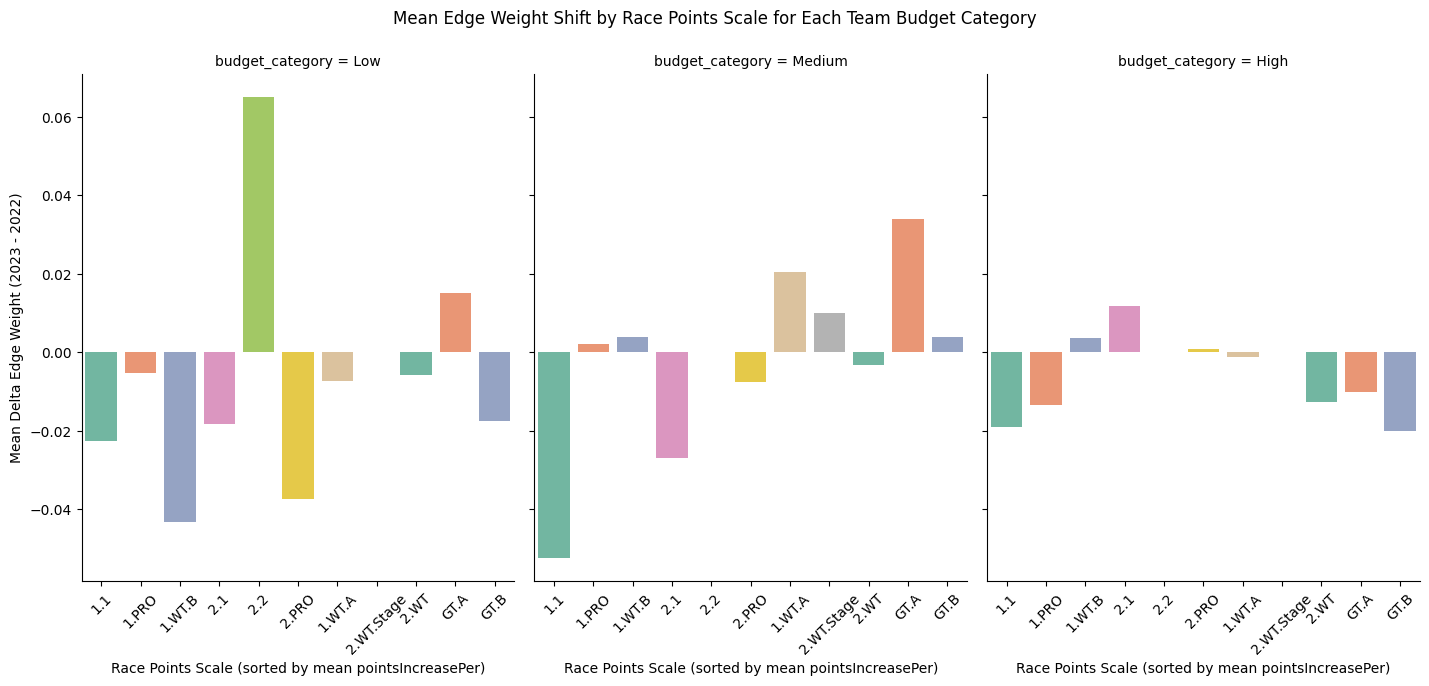

In [82]:
# Step 1: Compute the mean pointsIncreasePer for sorting
order_df = df_deltas.groupby('pointsScale', as_index=False)['pointsIncreasePer'].mean()
order_df = order_df.sort_values('pointsIncreasePer')  # Sort by mean pointsIncreasePer
sorted_order = order_df['pointsScale'].tolist()

# Step 2: Create the bar plot with automatic variance error bars
g = sns.catplot(
    x='pointsScale',
    y='delta_edge_weight',
    col='budget_category',
    data=df_deltas,
    kind='bar',  # Use Seaborn's bar plot with automatic variance
    col_order=["Low", "Medium", "High"],
    order=sorted_order,  # Sorted by mean pointsIncreasePer
    height=6,
    aspect=0.8,
    palette='Set2',
    ci=None  # **Disables variance/error bars**

)

# Step 3: Set labels and title
g.set_axis_labels("Race Points Scale (sorted by mean pointsIncreasePer)", "Mean Delta Edge Weight (2023 - 2022)")
g.fig.suptitle("Mean Edge Weight Shift by Race Points Scale for Each Team Budget Category", y=1.05)

# Rotate x-axis labels for clarity
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

In [84]:
def visualize_graph_bipartite_clustered(G, num_clusters=4, cluster_gap=0.1):
    # Separate nodes into teams and races.
    team_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'team']
    race_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'race']
    
    # --- Team Nodes: assign uniform positions on left ---
    pos = {}
    team_y = np.linspace(0, 1, len(team_nodes))
    for i, n in enumerate(team_nodes):
        pos[n] = (0, team_y[i])
    
    # --- Race Nodes: Cluster by pointsIncreasePer ---
    # Get race_points for each race node.
    race_points = np.array([G.nodes[n].get('pointsIncreasePer', 0) for n in race_nodes])
    
    # Determine quantile thresholds for clustering.
    thresholds = np.percentile(race_points, np.linspace(0, 100, num_clusters+1))
    
    # Assign each race node to a cluster based on its pointsIncreasePer.
    race_cluster = {}
    for n in race_nodes:
        value = G.nodes[n].get('pointsIncreasePer', 0)
        # Find cluster index
        for i in range(num_clusters):
            # include upper bound in last cluster
            if i < num_clusters - 1:
                if thresholds[i] <= value < thresholds[i+1]:
                    race_cluster[n] = i
                    break
            else:
                if thresholds[i] <= value <= thresholds[i+1]:
                    race_cluster[n] = i
                    break
    
    # Group race nodes by cluster.
    cluster_dict = {}
    for n, cl in race_cluster.items():
        cluster_dict.setdefault(cl, []).append(n)
    
    # Now assign positions for race nodes by cluster.
    # The vertical space (0 to 1) is divided among clusters with gaps.
    cluster_height = (1 - (num_clusters - 1) * cluster_gap) / num_clusters
    for cluster_idx, nodes in cluster_dict.items():
        # Sort nodes in this cluster by their pointsIncreasePer value.
        nodes_sorted = sorted(nodes, key=lambda n: G.nodes[n].get('pointsIncreasePer', 0))
        # Create y positions within this cluster's segment.
        y_values = np.linspace(0, cluster_height, len(nodes_sorted))
        # Compute vertical offset for this cluster.
        offset = cluster_idx * (cluster_height + cluster_gap)
        for i, n in enumerate(nodes_sorted):
            pos[n] = (1, y_values[i] + offset)
    
    # --- Team Nodes: Color by Budget Category ---
    team_budget = {n: G.nodes[n].get('budget_category', 'Unknown') for n in team_nodes}
    unique_budget = list(set(team_budget.values()))
    palette = plt.cm.tab10.colors  
    budget_color_map = {cat: palette[i % len(palette)] for i, cat in enumerate(unique_budget)}
    team_colors = [budget_color_map[team_budget[n]] for n in team_nodes]
    
    # --- Race Nodes: Size and Color by Points Increase ---
    # We use the original race_points array for color and size.
    race_points_for_color = np.array([G.nodes[n].get('pointsIncreasePer', 0) for n in race_nodes])
    race_sizes = 300 + (race_points_for_color - race_points_for_color.min()) / (race_points_for_color.ptp() + 1e-6) * 500
    norm = mcolors.Normalize(vmin=race_points_for_color.min(), vmax=race_points_for_color.max())
    race_colors = [plt.cm.coolwarm(norm(G.nodes[n].get('pointsIncreasePer', 0))) for n in race_nodes]
    
    # --- Draw Nodes and Edges ---
    fig, ax = plt.subplots(figsize=(24, 16))
    nx.draw_networkx_nodes(G, pos, nodelist=team_nodes, node_color=team_colors, node_size=500, ax=ax)
    nx.draw_networkx_nodes(G, pos, nodelist=race_nodes, node_color=race_colors, node_size=race_sizes, ax=ax)
    
    edge_weights = [data.get('edge_weight', 1) for _, _, data in G.edges(data=True)]
    scaled_widths = [w * 0.5 for w in edge_weights]
    nx.draw_networkx_edges(G, pos, width=scaled_widths, ax=ax)
    
    labels = {}
    for n, d in G.nodes(data=True):
        if d.get('node_type') == 'team':
            labels[n] = d.get('team_name', n)
    nx.draw_networkx_labels(G, pos, labels, font_size=8, ax=ax)
    
    # --- Add Colorbar for Race Nodes (Points Increase) ---
    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Points Increase (%)')
    
    ax.set_axis_off()
    plt.show()

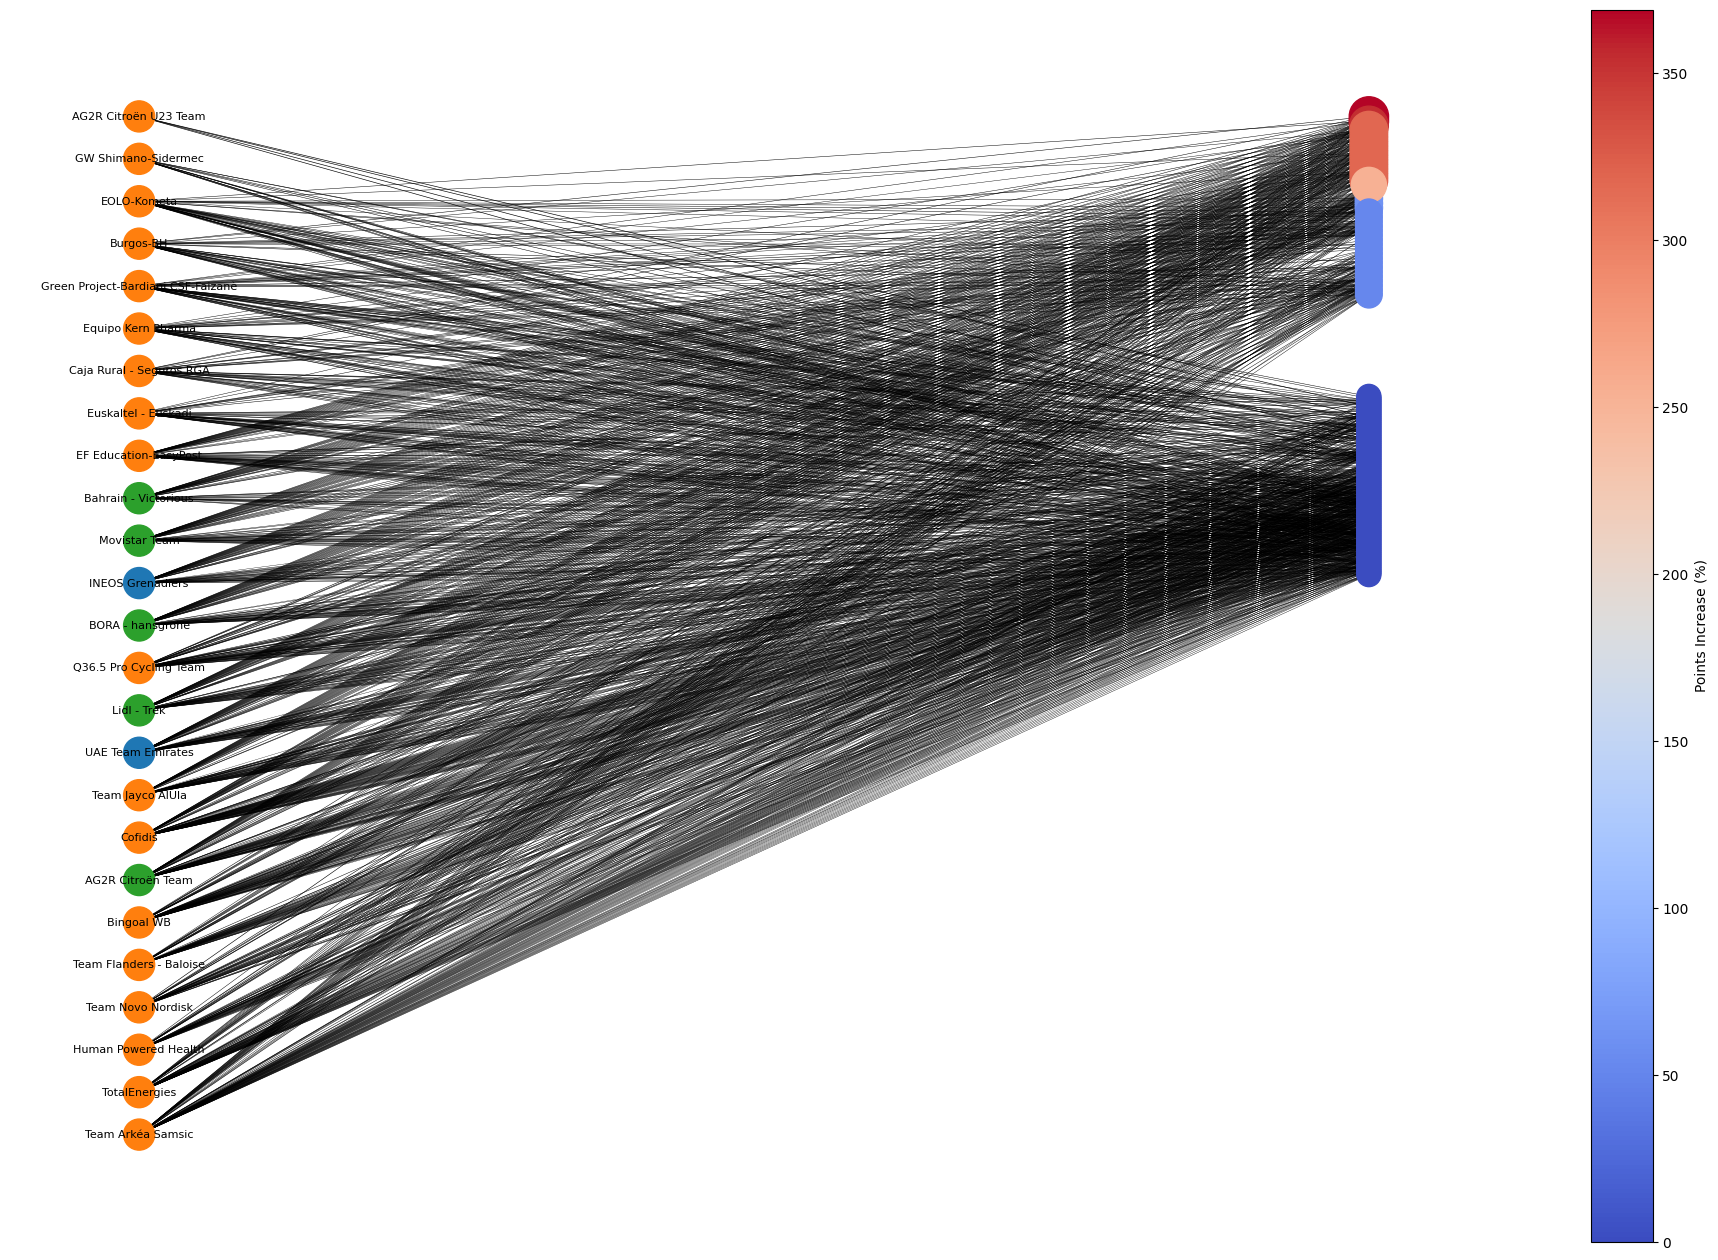

In [85]:
G_year = graph_by_year[2023]
visualize_graph_bipartite_clustered(G_year)

C:\Users\User\AppData\Local\Temp\ipykernel_14644\1932652610.py:96: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



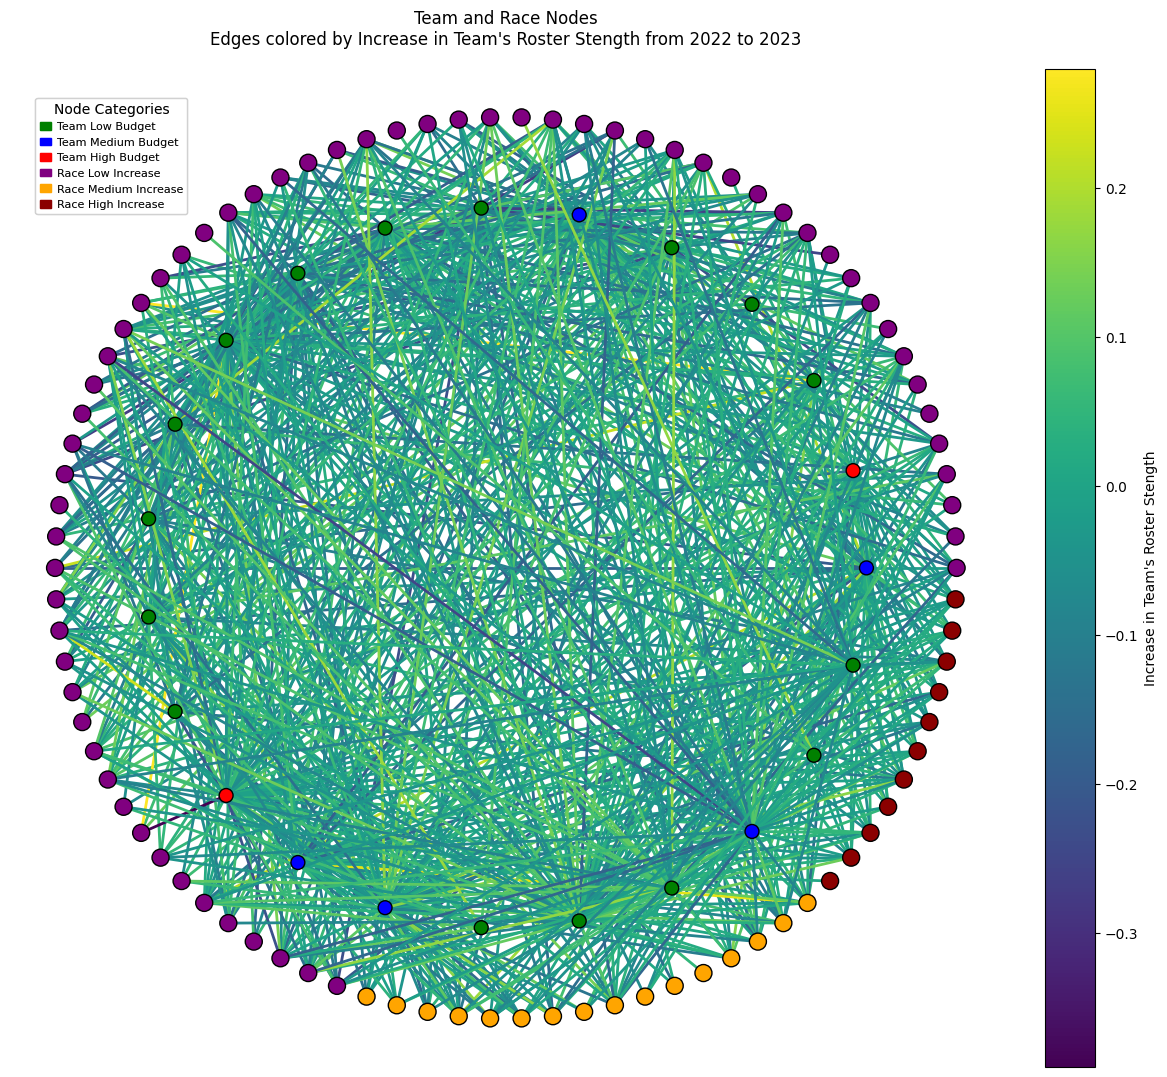

In [86]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import math

def radial_layout(G, team_radius=0.3, race_radius=1.0):
    """
    Compute a radial layout for graph G.
    Team nodes are placed evenly on an inner circle (radius=team_radius).
    Race nodes are placed evenly on an outer circle (radius=race_radius) and sorted by their pointsIncreasePer.
    """
    pos = {}
    team_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'team']
    race_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'race']
    
    n_team = len(team_nodes)
    for i, n in enumerate(team_nodes):
        angle = 2 * math.pi * i / n_team
        pos[n] = (team_radius * math.cos(angle), team_radius * math.sin(angle))
    
    # Sort race nodes by their pointsIncreasePer (defaulting to 0 if not present)
    race_nodes_sorted = sorted(race_nodes, key=lambda n: G.nodes[n].get('pointsIncreasePer', 0))
    n_race = len(race_nodes_sorted)
    for i, n in enumerate(race_nodes_sorted):
        angle = 2 * math.pi * i / n_race
        pos[n] = (race_radius * math.cos(angle), race_radius * math.sin(angle))
    return pos


def build_graph_from_deltas(df_deltas):
    """
    Given a DataFrame (df_deltas) with common edges and a computed delta_edge_weight,
    build a new networkx graph using node attributes from the 2023 graph.
    Only include edges where delta_edge_weight != 0.
    Assumes df_deltas contains columns:
      - 'team'
      - 'race'
      - 'delta_edge_weight'
    """
    G_new = nx.Graph()
    
    # Get unique team and race IDs from df_deltas.
    teams = set(df_deltas['team'])
    races = set(df_deltas['race'])
    
    # Assume access to graph_by_year[2023] for node attributes.
    G_2023 = graph_by_year[2023]
    
    for n in teams:
        if n in G_2023.nodes:
            G_new.add_node(n, **G_2023.nodes[n])
    for n in races:
        if n in G_2023.nodes:
            G_new.add_node(n, **G_2023.nodes[n])
            
    # Add edges (only those with nonzero delta_edge_weight).
    for idx, row in df_deltas.iterrows():
        if row['delta_edge_weight'] != 0:
            G_new.add_edge(row['team'], row['race'], delta_edge_weight=row['delta_edge_weight'])
    return G_new

def build_frame_data_custom(G, pos):
    """
    Build static plot data from graph G using positions pos.
    - Edges are drawn as lines and colored by their delta_edge_weight (regular value, normalized via viridis).
    - Team nodes are colored by budget (low: green, medium: blue, high: red).
    - Race nodes are colored by their points_increase_bin (Low: purple, Medium: orange, High: darkred).
    
    Returns:
      edge_lines: list of ((x0,y0),(x1,y1)) for each edge.
      edge_colors: list of colors for each edge.
      team_x, team_y, team_colors: lists for team nodes.
      race_x, race_y, race_colors: lists for race nodes.
      norm_edge, cmap_edge: normalization object and colormap for edge weights.
    """
    # Process edge data.
    edge_traces = []
    for u, v, data in G.edges(data=True):
        x0, y0 = pos[u]
        x1, y1 = pos[v]
        delta = data.get('delta_edge_weight', 0)  # use regular delta value
        edge_traces.append((u, v, x0, y0, x1, y1, delta))
    
    edge_lines = [((et[2], et[3]), (et[4], et[5])) for et in edge_traces]
    edge_deltas = [et[6] for et in edge_traces]
    
    # Normalize edge delta values.
    if edge_deltas:
        min_delta, max_delta = min(edge_deltas), max(edge_deltas)
    else:
        min_delta, max_delta = 0, 1
    norm_edge = mcolors.Normalize(vmin=min_delta, vmax=max_delta)
    cmap_edge = cm.get_cmap('viridis')
    def map_edge_color(val):
        if max_delta > min_delta:
            norm_val = (val - min_delta) / (max_delta - min_delta)
        else:
            norm_val = 0.5
        return mcolors.to_hex(cmap_edge(norm_val))
    edge_colors = [map_edge_color(val) for val in edge_deltas]
    
    # Process team nodes.
    team_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'team']
    team_x = [pos[n][0] for n in team_nodes]
    team_y = [pos[n][1] for n in team_nodes]
    team_colors = []
    for n in team_nodes:
        d = G.nodes[n]
        budget = str(d.get('budget_category', 'Unknown')).lower()
        if budget == 'low':
            team_colors.append('green')
        elif budget == 'medium':
            team_colors.append('blue')
        elif budget == 'high':
            team_colors.append('red')
        else:
            team_colors.append('gray')
    
    # Process race nodes.
    race_nodes = [n for n, d in G.nodes(data=True) if d.get('node_type') == 'race']
    race_x = [pos[n][0] for n in race_nodes]
    race_y = [pos[n][1] for n in race_nodes]
    # Use discrete mapping for race nodes based on 'points_increase_bin' (or pointsIncreaseCat).
    race_color_map = {"Low": "purple", "Medium": "orange", "High": "darkred"}
    race_colors = []
    for n in race_nodes:
        d = G.nodes[n]
        # Here we assume the race node has attribute 'pointsIncreaseCat'
        bin_val = d.get('pointsIncreaseCat', "Low")
        bin_val = str(bin_val).title()  # convert to title case: Low, Medium, High
        race_colors.append(race_color_map.get(bin_val, 'gray'))
    
    return edge_lines, edge_colors, team_x, team_y, team_colors, race_x, race_y, race_colors, norm_edge, cmap_edge

def draw_static_network_custom(G, pos):
    """
    Draw a static network plot using Matplotlib.
    - Team nodes: colored by budget (low: green, medium: blue, high: red).
    - Race nodes: colored by points_increase_bin (Low: purple, Medium: orange, High: darkred).
    - Edges: colored by delta_edge_weight (regular value, normalized via viridis).
    A combined legend is added: the node legend is placed in the upper left inside the plot,
    and a colorbar for edge weights is placed to the right.
    """
    # Get plotting data.
    edge_lines, edge_colors, team_x, team_y, team_colors, race_x, race_y, race_colors, norm_edge, cmap_edge = build_frame_data_custom(G, pos)
    
    # Increase figure size.
    fig, ax = plt.subplots(figsize=(14,14))
    
    # Draw edges.
    for ((x0, y0), (x1, y1)), color in zip(edge_lines, edge_colors):
        ax.plot([x0, x1], [y0, y1], color=color, linewidth=2)
    
    # Draw team nodes.
    ax.scatter(team_x, team_y, s=100, c=team_colors, edgecolors='k', zorder=3)
    # Draw race nodes.
    ax.scatter(race_x, race_y, s=150, c=race_colors, edgecolors='k', zorder=3)
    
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Create dummy legend entries for nodes.
    # Team nodes legend.
    team_patch_low = mpatches.Patch(color='green', label='Team Low Budget')
    team_patch_medium = mpatches.Patch(color='blue', label='Team Medium Budget')
    team_patch_high = mpatches.Patch(color='red', label='Team High Budget')
    # Race nodes legend.
    race_patch_low = mpatches.Patch(color='purple', label='Race Low Increase')
    race_patch_medium = mpatches.Patch(color='orange', label='Race Medium Increase')
    race_patch_high = mpatches.Patch(color='darkred', label='Race High Increase')
    
    node_legend = [team_patch_low, team_patch_medium, team_patch_high,
                   race_patch_low, race_patch_medium, race_patch_high]
    
    # Place the node legend in the upper left inside the plot.
    # Place the node legend in the upper left inside the plot and make it smaller.
    leg = ax.legend(handles=node_legend, title="Node Categories", loc='upper left', 
                    bbox_to_anchor=(0.02, 0.98), prop={'size': 8},
                    handlelength=1.0, handletextpad=0.5)
    ax.add_artist(leg)
    
    # Create a colorbar for edge weights.
    sm = plt.cm.ScalarMappable(cmap=cmap_edge, norm=norm_edge)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Increase in Team's Roster Stength")
    
    plt.title("Team and Race Nodes\nEdges colored by Increase in Team's Roster Stength from 2022 to 2023", y=1.02)
    plt.show()

# --- Usage Example ---
# Assume that 'df_deltas' is your DataFrame of delta edges (with nonzero delta_edge_weight)
# and that 'graph_by_year' is a dictionary with graphs for each year, with 2023 available.
# Build your delta graph for 2023:
df_deltas_nonzero = df_deltas[df_deltas['delta_edge_weight'] != 0]
G_delta = build_graph_from_deltas(df_deltas_nonzero)
# Compute a radial layout for the delta graph.
pos_delta = radial_layout(G_delta, team_radius=0.2, race_radius=0.25)
# Draw the static network with custom legends.
draw_static_network_custom(G_delta, pos_delta)
